# Helth Insurance Cross Sell Prediction

## 1. Objective

Develop a machine learning model capable of estimating the probability that each health insurance customer will also purchase vehicle insurance. Based on these probabilities, generate a **ranked list of customers by purchase propensity**, allowing the company to prioritize those with the highest likelihood of conversion and, therefore, optimize the *cross-sell* strategy and the use of marketing resources.


## 2. Executive Summary




This project developed a **machine learning model to predict the probability that health insurance customers will also purchase vehicle insurance**, with the goal of **prioritizing commercial outreach** and maximizing the return of *cross-sell* actions.

The dataset used contains **76,220 customers**, reflecting a real scenario in the insurance industry: many clients, few buyers, and a strong need to identify those with higher conversion propensity. Since this is a **highly imbalanced problem**, the model was designed to maximize the recovery of buyers while maintaining operational precision.

After training and optimization, the model achieved **strong predictive performance**, with:

* **AUC-ROC:** 0.858
* **AUC-PR:** 0.368
* **Optimized F1-score:** 0.4609
* **Positive-class recall:** 76%
* **Moderate precision:** 33%

The key advantage lies in using the model to **rank customers by purchase probability**, allowing the company to focus efforts on the most promising segments.

By selecting **only the top 20% most likely to buy**, the financial impact is significant:

* **Profit without model:** R$ 762,200
* **Profit with model:** R$ 2,025,417
* **Additional gain:** R$ 1,263,217
* **ROI vs. random:** +165.7%
* **Return multiplied by:** 2.65×

These results show that the model **transforms the campaign**, shifting from a volume-based approach to one driven by **predictive intelligence**. Even with moderate precision, common in this type of problem. The model is able to **recover most potential buyers** and direct commercial resources far more efficiently.

In summary, the model:

* Reduces operational waste
* Significantly increases conversion
* Generates more than **R$ 1.26 million** in additional profit
* Makes the *cross-sell* process **more strategic and highly profitable**

This outcome demonstrates the power of applying machine learning to business decisions and shows how propensity models can become **direct drivers of value creation**.


## 3. Sobre os Dados

A base de dados utilizada reúne **76.220 clientes de uma seguradora de saúde**, incluindo informações gerais sobre perfil, histórico e relacionamento com a empresa. Cada registro representa um cliente e indica se ele aceitou ou não uma oferta de **seguro veicular**, caracterizando um típico problema de *cross-sell*.

Os dados refletem um cenário realista do mercado de seguros: muitos clientes, poucos compradores e a necessidade de identificar quem tem maior probabilidade de aceitar uma oferta adicional. Trata-se de um conjunto **desbalanceado**, no qual a maior parte dos clientes não compra o produto.


## 4. Getting Started

### 4.1 Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier as lgb
from sklearn.model_selection import KFold
import optuna
import pickle
import shap
from sklearn.metrics import recall_score, precision_score, f1_score,roc_auc_score, average_precision_score, classification_report, confusion_matrix
import lightgbm as lgb



### 4.2 Importing Style

In [87]:
plt.style.use('../styles/personalestilo.mplstyle')


Bad key axes.color_cycle in file ../styles/personalestilo.mplstyle, line 9 ('axes.color_cycle: df691b, 5cb85c, 5bc0de, f0ad4e, d9534f, 4e5d6c')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.6/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


### 4.3 Additional Functions

In [ ]:
def snake_case(lst):
    def convert(s):
        s = s.replace(' ', '_')
        new_s = ""
        for i, c in enumerate(s):
            if c.isupper():
                if i > 0 and (s[i-1].islower() or (i+1 < len(s) and s[i+1].islower())):
                    new_s += "_"
                new_s += c.lower()
            else:
                new_s += c
        return new_s

    return [convert(s) for s in lst]

def get_metrics_at_k(X_validation, y_validation, y_proba, model_name, k=2000):
    df = X_validation.copy()
    df['response'] = y_validation
    df['score'] = y_proba[:, 1]

    df_sorted = df[['response', 'score']].sort_values('score', ascending=False).reset_index(drop=True)

    df_sorted['precision_at_k'] = df_sorted['response'].cumsum() / (np.arange(1, len(df_sorted) + 1))
    precision_at_k = df_sorted.loc[k, 'precision_at_k']

    recall_at_k = df_sorted.loc[:k, 'response'].sum() / df_sorted['response'].sum()

    if (precision_at_k + recall_at_k) == 0:
        f1_at_k = 0.0
    else:
        f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)

    top_k = df_sorted.loc[:k, 'response'].values
    discounts = np.log2(np.arange(2, len(top_k) + 2))
    dcg = (top_k / discounts).sum()
    ideal_top_k = np.sort(df_sorted['response'].values)[::-1][:len(top_k)]
    ideal_dcg = (ideal_top_k / discounts).sum()
    ndcg_at_k = dcg / ideal_dcg if ideal_dcg > 0 else 0.0

    results = pd.DataFrame([{
        'model': model_name,
        f'precision@{k}': precision_at_k,
        f'recall@{k}': recall_at_k,
        f'f1@{k}': f1_at_k,
        f'ndcg@{k}': ndcg_at_k
    }])

    return results


def avaliar_metricas(modelo, X_val, y_val, X_test, y_test):

    def obter_prob(modelo, X):

        if hasattr(modelo, "predict_proba"):
            probas = modelo.predict_proba(X)
            return probas[:, 1]
        elif hasattr(modelo, "predict"):

            if isinstance(X, (pd.DataFrame, pd.Series, np.ndarray)):
                dmatrix = xgb.DMatrix(X)
            else:
                dmatrix = X
            probas = modelo.predict(dmatrix)
            return probas
        else:
            raise ValueError("O modelo precisa implementar predict_proba ou ser booster do xgboost.")

    y_val_prob = obter_prob(modelo, X_val)
    y_test_prob = obter_prob(modelo, X_test)

    y_val_pred = (y_val_prob >= 0.5).astype(int)
    y_test_pred = (y_test_prob >= 0.5).astype(int)

    metrics = {
        'recall': [
            recall_score(y_val, y_val_pred),
            recall_score(y_test, y_test_pred)
        ],
        'precision': [
            precision_score(y_val, y_val_pred),
            precision_score(y_test, y_test_pred)
        ],
        'f1_score': [
            f1_score(y_val, y_val_pred),
            f1_score(y_test, y_test_pred)
        ],
        'auc_roc': [
            roc_auc_score(y_val, y_val_prob),
            roc_auc_score(y_test, y_test_prob)
        ],
        'auc_pr': [
            average_precision_score(y_val, y_val_prob),
            average_precision_score(y_test, y_test_prob)
        ]
    }
    df_metrics = pd.DataFrame(metrics, index=['validacao', 'teste']).T
    return df_metrics
def find_best_threshold(y_true, y_proba, metric="f1"):
    thresholds = np.linspace(0, 1, 200)

    best_t = 0.5
    best_score = -1

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        if metric == "f1":
            score = f1_score(y_true, y_pred)
        elif metric == "mcc":
            score = matthews_corrcoef(y_true, y_pred)
        elif metric == "recall":
            score = recall_score(y_true, y_pred)
        elif metric == "precision":
            score = precision_score(y_true, y_pred)
        elif metric == "f2":
            score = fbeta_score(y_true, y_pred, beta=2)
        elif metric == "f05":
            score = fbeta_score(y_true, y_pred, beta=0.5)
        else:
            raise ValueError("Métrica inválida.")

        if score > best_score:
            best_score = score
            best_t = t

    return best_t, best_score
    
class OptunaProgressCallback:
    def __init__(self, total_iters):
        self.total = total_iters
        self.current = 0

    def __call__(self, study, trial):
        self.current += 1
        pct = 100 * self.current / self.total
        print(f"📊 Progresso: {self.current}/{self.total}  ({pct:.1f}%) - Current best value: {study.best_value:.5f}")
        
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 2000, 6000),
        'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 50, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 300, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.0),
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 40),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'random_state': 42,
        'eval_metric': 'auc',
        'tree_method': 'hist',
    }


    model = xgb.XGBClassifier(**param)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    roc_auc_scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X_full, y_full)):
        X_train_fold, X_val_fold = X_full.iloc[train_index], X_full.iloc[val_index]
        y_train_fold, y_val_fold = y_full.iloc[train_index], y_full.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)

        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        roc_auc = roc_auc_score(y_val_fold, y_pred_proba)

        roc_auc_scores.append(roc_auc)

    return np.mean(roc_auc_scores)

print("Optuna objective function 'objective' defined successfully.")



### 4.4 Loading the Data

In [89]:
data = pd.read_csv('../data/train.csv')


In [90]:
data.head().T

,0,1,2,3,4
id,1,2,3,4,5
Gender,Male,Male,Male,Male,Female
Age,44,76,47,21,29
Driving_License,1,1,1,1,1
Region_Code,28.0,3.0,28.0,11.0,41.0
Previously_Insured,0,0,0,1,1
Vehicle_Age,> 2 Years,1-2 Year,> 2 Years,< 1 Year,< 1 Year
Vehicle_Damage,Yes,No,Yes,No,No
Annual_Premium,40454.0,33536.0,38294.0,28619.0,27496.0
Policy_Sales_Channel,26.0,26.0,26.0,152.0,152.0


## 5. Data Description

In [91]:
df1 = data

### 5.1 Renaming Columns

In [92]:
print(df1.columns)


Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


In [93]:
df1.columns = snake_case(df1.columns)

In [94]:
print(df1.columns)

Index(['id', 'gender', 'age', 'driving__license', 'region__code',
       'previously__insured', 'vehicle__age', 'vehicle__damage',
       'annual__premium', 'policy__sales__channel', 'vintage', 'response'],
      dtype='object')


### 5.2 Data Dimensions

In [95]:
print("Número de linhas:", data.shape[0])
print("Número de colunas:", data.shape[1])

Número de linhas: 381109
Número de colunas: 12


### 5.3 Data Types

In [96]:
df1.dtypes

id                          int64
gender                     object
age                         int64
driving__license            int64
region__code              float64
previously__insured         int64
vehicle__age               object
vehicle__damage            object
annual__premium           float64
policy__sales__channel    float64
vintage                     int64
response                    int64
dtype: object

#### 5.3.1 Vehicle Damage

In [97]:
df1['vehicle__damage'] = df1['vehicle__damage'].map({'Yes': 1, 'No': 0}).astype(int)


### 5.4 Checking and Filling NAN Values

In [ ]:

print("Valores ausentes por coluna:")
print(df1.isnull().sum())


Valores ausentes por coluna:
id                        0
gender                    0
age                       0
driving__license          0
region__code              0
previously__insured       0
vehicle__age              0
vehicle__damage           0
annual__premium           0
policy__sales__channel    0
vintage                   0
response                  0
dtype: int64


In [ ]:

print("Valores zero e negativos por coluna:")
for col in df1.columns:
    if pd.api.types.is_numeric_dtype(df1[col]):
        zeros = (df1[col] == 0).sum()
        negativos = (df1[col] < 0).sum()
        print(f"{col}: zeros = {zeros}, negativos = {negativos}")


Valores zero e negativos por coluna:
id: zeros = 0, negativos = 0
age: zeros = 0, negativos = 0
driving__license: zeros = 812, negativos = 0
region__code: zeros = 2021, negativos = 0
previously__insured: zeros = 206481, negativos = 0
vehicle__damage: zeros = 188696, negativos = 0
annual__premium: zeros = 0, negativos = 0
policy__sales__channel: zeros = 0, negativos = 0
vintage: zeros = 0, negativos = 0
response: zeros = 334399, negativos = 0


### 5.5 Descriptive Statistics

In [100]:
df_numeric = df1.select_dtypes(include=['int64', 'float64'])

df_categorical = df1.select_dtypes(include=['object'])

#### 5.5.1 Numerical Variables

In [101]:
numerical_stats = pd.DataFrame({
    'mean': df_numeric.mean(),
    'median': df_numeric.median(),
    'std': df_numeric.std(),
    'min': df_numeric.min(),
    'max': df_numeric.max(),
    'range': df_numeric.max() - df_numeric.min(),
    'skew': df_numeric.skew(),
    'kurtosis': df_numeric.kurt()
})

display(numerical_stats)



,mean,median,std,min,max,range,skew,kurtosis
id,190555.000000,190555.0,110016.836208,1.0,381109.0,381108.0,0.000000,-1.200000
age,38.822584,36.0,15.511611,20.0,85.0,65.0,0.672539,-0.565655
driving__license,0.997869,1.0,0.046110,0.0,1.0,1.0,-21.595182,464.354302
region__code,26.388807,28.0,13.229888,0.0,52.0,52.0,-0.115266,-0.867857
previously__insured,0.458210,0.0,0.498251,0.0,1.0,1.0,0.167747,-1.971871
vehicle__damage,0.504877,1.0,0.499977,0.0,1.0,1.0,-0.019507,-1.999630
annual__premium,30564.389581,31669.0,17213.155057,2630.0,540165.0,537535.0,1.766087,34.004569
policy__sales__channel,112.034295,133.0,54.203995,1.0,163.0,162.0,-0.900008,-0.970810
vintage,154.347397,154.0,83.671304,10.0,299.0,289.0,0.003030,-1.200688
response,0.122563,0.0,0.327936,0.0,1.0,1.0,2.301906,3.298788


**Business Analysis**

**Id (identifier):**
The identifier is a purely administrative variable with no direct analytical meaning. Its mean and median are nearly identical (≈190,555), with a uniform distribution and no skew (skew = 0). It should not be used in the model, serving only as an index reference.

**Age:**
The average customer age is about 38.8 years, with a median of 36, indicating slight positive skewness (skew = 0.67). Ages range from 20 to 85, with moderate variation (std ≈ 15.5). This suggests the customer base is primarily composed of middle-aged adults, potentially with greater financial stability and a higher propensity to purchase insurance.

**Driving License:**
Almost all customers have a driver’s license (mean ≈ 0.998). The low dispersion (std = 0.046) shows this variable has very little variability, essentially constant. It may contribute little predictive value to the model.

**Region Code:**
Mean of 26.3 and median of 28 indicate good centralization. The range (52) and standard deviation (≈13.2) reflect moderate regional variation, which may capture geographical differences among customer profiles. The distribution is nearly symmetric (skew ≈ -0.11).

**Previously Insured:**
Approximately 45.8% of customers previously held insurance, while 54.2% are new to the segment. The slight positive skew (0.17) confirms this mild predominance of non-insured individuals, which may be an important predictor of purchase propensity.

**Annual Premium:**
One of the most significant variables. The mean annual premium is about R$ 30,564, with a median of R$ 31,669. However, the high standard deviation (≈17,213) and maximum value of R$ 540,165 reveal large dispersion and the presence of outliers. The strong positive skew (skew = 1.77) and extremely high kurtosis (34.0) confirm concentration around lower values with a few extremely high premiums. A transformation is recommended before modeling.

**Policy Sales Channel:**
The sales channel variable has a mean of 112, median of 133, and high standard deviation (≈54.2), suggesting a diverse range of sales channels. The slight negative skew (skew = -0.99) indicates that higher-coded channels are somewhat less common, potentially reflecting preference for a few primary channels.

**Vintage (customer tenure):**
Mean and median are nearly identical (≈154 days), with a standard deviation of ≈83.6. The distribution is almost perfectly symmetric (skew ≈ 0.00), showing a balanced mix of new and long-term customers. This may be a relevant variable as it can reflect loyalty and repurchase behavior.

**Response (target variable):**
The response rate is 12.2%, meaning only a small portion of customers accepted the offer. The positive skew (2.3) confirms the strong imbalance in the target variable, requiring balancing techniques (undersampling, oversampling, or SMOTE) during model training.


### 5.5.2 Categorical Variables


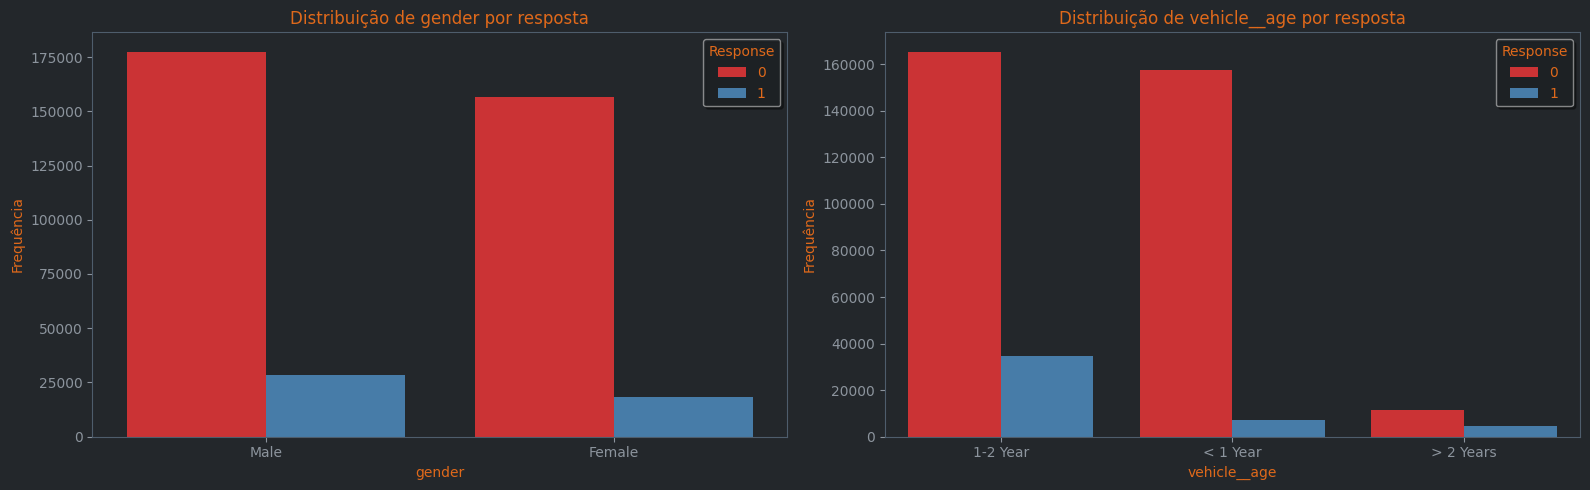

In [102]:
categorical_vars = df_categorical.columns

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, var in enumerate(categorical_vars):
    df_plot = df1.copy()
    df_plot[var] = df_plot[var].astype(str)
    order = df_plot[var].value_counts().index
    sns.countplot(data=df_plot, x=var, hue='response', palette='Set1', order=order, ax=axes[idx])
    axes[idx].set_title(f'Distribuição de {var} por resposta')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('Frequência')
    axes[idx].legend(title='Response')

plt.tight_layout()
plt.show()



**Gender:**

The distribution shows a slight predominance of male customers, both in the non-response group (Response = 0) and in the positive response group (Response = 1). However, men present a higher absolute number of positive responses compared to women, indicating a slightly higher propensity to accept the offer among male customers. Even so, the difference is not drastic, suggesting that gender alone is not a strong determinant of campaign response.


**Vehicle Age:**

Customers with vehicles between **1 and 2 years old** represent the largest portion of the dataset and also concentrate the highest number of positive responses, which may indicate greater interest in renewing or upgrading insurance within this vehicle age range. Vehicles **under 1 year old** have a high overall frequency but a low response rate, possibly because owners of newer cars still feel protected by their original insurance coverage.

In contrast, vehicles **over 2 years old** have a smaller volume but maintain a reasonable proportion of positive responses, potentially representing a more loyal segment or one with a higher perceived need for protection due to the vehicle’s age.


## 6. Feature Engineering


In [115]:
df2 = df1

### 6.1 Hypothesis Creation


H1 — Older customers (age) have a higher probability of purchasing the insurance.

H2 — Customers who hold a driver's license (driving_license = 1) have a higher likelihood of buying the insurance.

H3 — Customers with previous insurance history (previously_insured = 1) have a lower propensity to purchase again.

H4 — Newer vehicles (vehicle_age = "< 1 year") are associated with higher purchase rates.

H5 — Customers whose vehicle has suffered prior damage (vehicle_damage = 1) show a higher probability of purchasing insurance.

H6 — Customers with higher annual premiums (annual_premium) tend to have lower conversion rates.

H7 — Certain regions (region_code) exhibit a higher propensity to purchase insurance.

H8 — The sales channel (policy_sales_channel) significantly influences the conversion rate.

H9 — Customers with longer tenure (vintage) with the company have a higher probability of accepting the offer.

H10 — Gender (gender) influences the propensity to purchase insurance.

H11 — Customers with higher vehicle_risk have a lower probability of acquiring a new insurance policy.


### 6.2 Deriving Variables

#### 6.2.1 Numerical Encoding and Basic Features

In [116]:
df2['vehicle_age_num'] = df2['vehicle__age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
df2 = df2.drop(columns=['vehicle__age'])
df2['vehicle_risk'] = df2['vehicle_age_num'] + df2['vehicle__damage']
df2['premium_per_vintage'] = df2['annual__premium'] / df2['vintage']
df2['premium_per_age'] = df2['annual__premium'] / df2['age']
df2['premium_per_risk'] = df2['annual__premium'] / (df2['vehicle_risk'] + 1e-5)
df2['age_x_premium'] = df2['age'] * df2['annual__premium']
df2['age_x_vehicle_age_num'] = df2['age'] * df2['vehicle_age_num']
df2['damage_x_age_vehicle'] = df2['vehicle__damage'] * df2['vehicle_age_num']
df2['age_x_vintage'] = df2['age'] * df2['vintage']
df2['age_bucket'] = pd.cut(df2['age'], bins=[18, 30, 40, 50, 60, 100], labels=[0, 1, 2, 3, 4])
df2['age_x_bucket'] = df2['age'] * df2['age_bucket'].astype(int)
df2['premium_bucket'] = pd.qcut(df2['annual__premium'], q=5, labels=False)
df2['vintage_per_age'] = df2['vintage'] / df2['age']
df2['vintage_per_year'] = df2['vintage'] / 12
df2['age_squared'] = df2['age'] ** 2
df2['age_cubed'] = df2['age'] ** 3


#### 6.2.2 Regional and Channel-Based Statistics

In [117]:
region_counts = df2['region__code'].value_counts(normalize=True)
df2['region__popularity'] = df2['region__code'].map(region_counts)
channel_counts = df2['policy__sales__channel'].value_counts(normalize=True)
df2['channel_popularity'] = df2['policy__sales__channel'].map(channel_counts)
df2['region__avg_premium'] = df2['region__code'].map(
    df2.groupby('region__code')['annual__premium'].mean()
)
df2['policy__channel__avg_premium'] = df2['policy__sales__channel'].map(
    df2.groupby('policy__sales__channel')['annual__premium'].mean()
)
df2['premium_minus_region_avg'] = df2['annual__premium'] - df2['region__avg_premium']
conversion_by_region = df2.groupby('region__code')['response'].mean()
df2['region_conversion_rate'] = df2['region__code'].map(conversion_by_region)


#### 6.2.3 Other Composite Features

In [118]:
df2['insurance_need_score'] = (
    (df2['previously__insured'] == 0).astype(int) * 2 +
    df2['vehicle_risk'] +
    df2['vehicle__damage']
)
avg_premium_by_risk = df2.groupby('vehicle_risk')['annual__premium'].mean()
df2['premium_diff_risk'] = df2['annual__premium'] - df2['vehicle_risk'].map(avg_premium_by_risk)
df2['channel_x_previously'] = df2['policy__sales__channel'] * df2['previously__insured']
df2['channel_x_risk'] = df2['policy__sales__channel'] * df2['vehicle_risk']
df2['is_new_customer'] = (df2['vintage'] < df2['vintage'].median()).astype(int)
df2['avg_premium_same_age'] = df2.groupby('age')['annual__premium'].transform('mean')
df2['premium_rel_age'] = df2['annual__premium'] / df2['avg_premium_same_age']
df2['premium_age_percentile'] = df2.groupby('age')['annual__premium'].rank(pct=True)
df2['risk_alignment'] = df2['insurance_need_score'] * df2['vehicle_risk']


## 7. Exploratory Data Analysis

In [119]:
df3 = df2.copy()

### 7.1 Univariate Analysis

#### 7.1.1 Target Variable

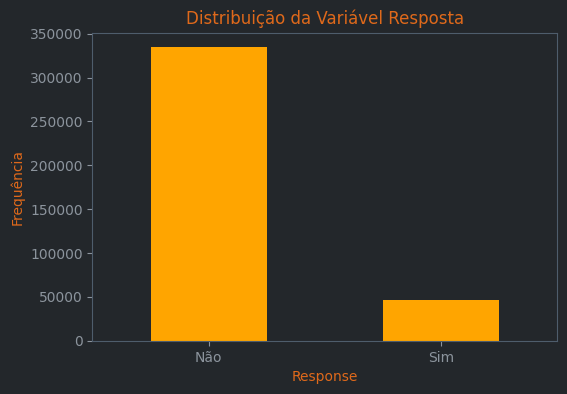

In [ ]:
plt.figure(figsize=(6,4))
df3['response'].value_counts().plot(kind='bar', color='orange')
plt.title('Distribuição da Variável Resposta')
plt.xlabel('Response')
plt.ylabel('Frequência')
plt.xticks([0,1], ['Não', 'Sim'], rotation=0)
plt.show()



The **Response** variable shows a highly imbalanced distribution, with a strong predominance of the "No" class compared to the "Yes" class. This indicates that the majority of customers did not purchase the insurance, while only a small portion responded positively to the campaign. This type of imbalance is common in binary classification problems focused on predicting customer purchase behavior, but it can negatively affect model performance by causing it to favor the majority class and overlook important patterns in the minority class.

To address this discrepancy and enable the model to properly learn patterns from both classes, it will be necessary to apply **data balancing techniques**, such as oversampling (e.g., SMOTE or RandomOverSampler) or undersampling, depending on the strategy and dataset size. These techniques help prevent bias toward the dominant class and improve the model’s ability to accurately identify customers with higher purchase propensity.


#### 7.1.2 Numerical Variables


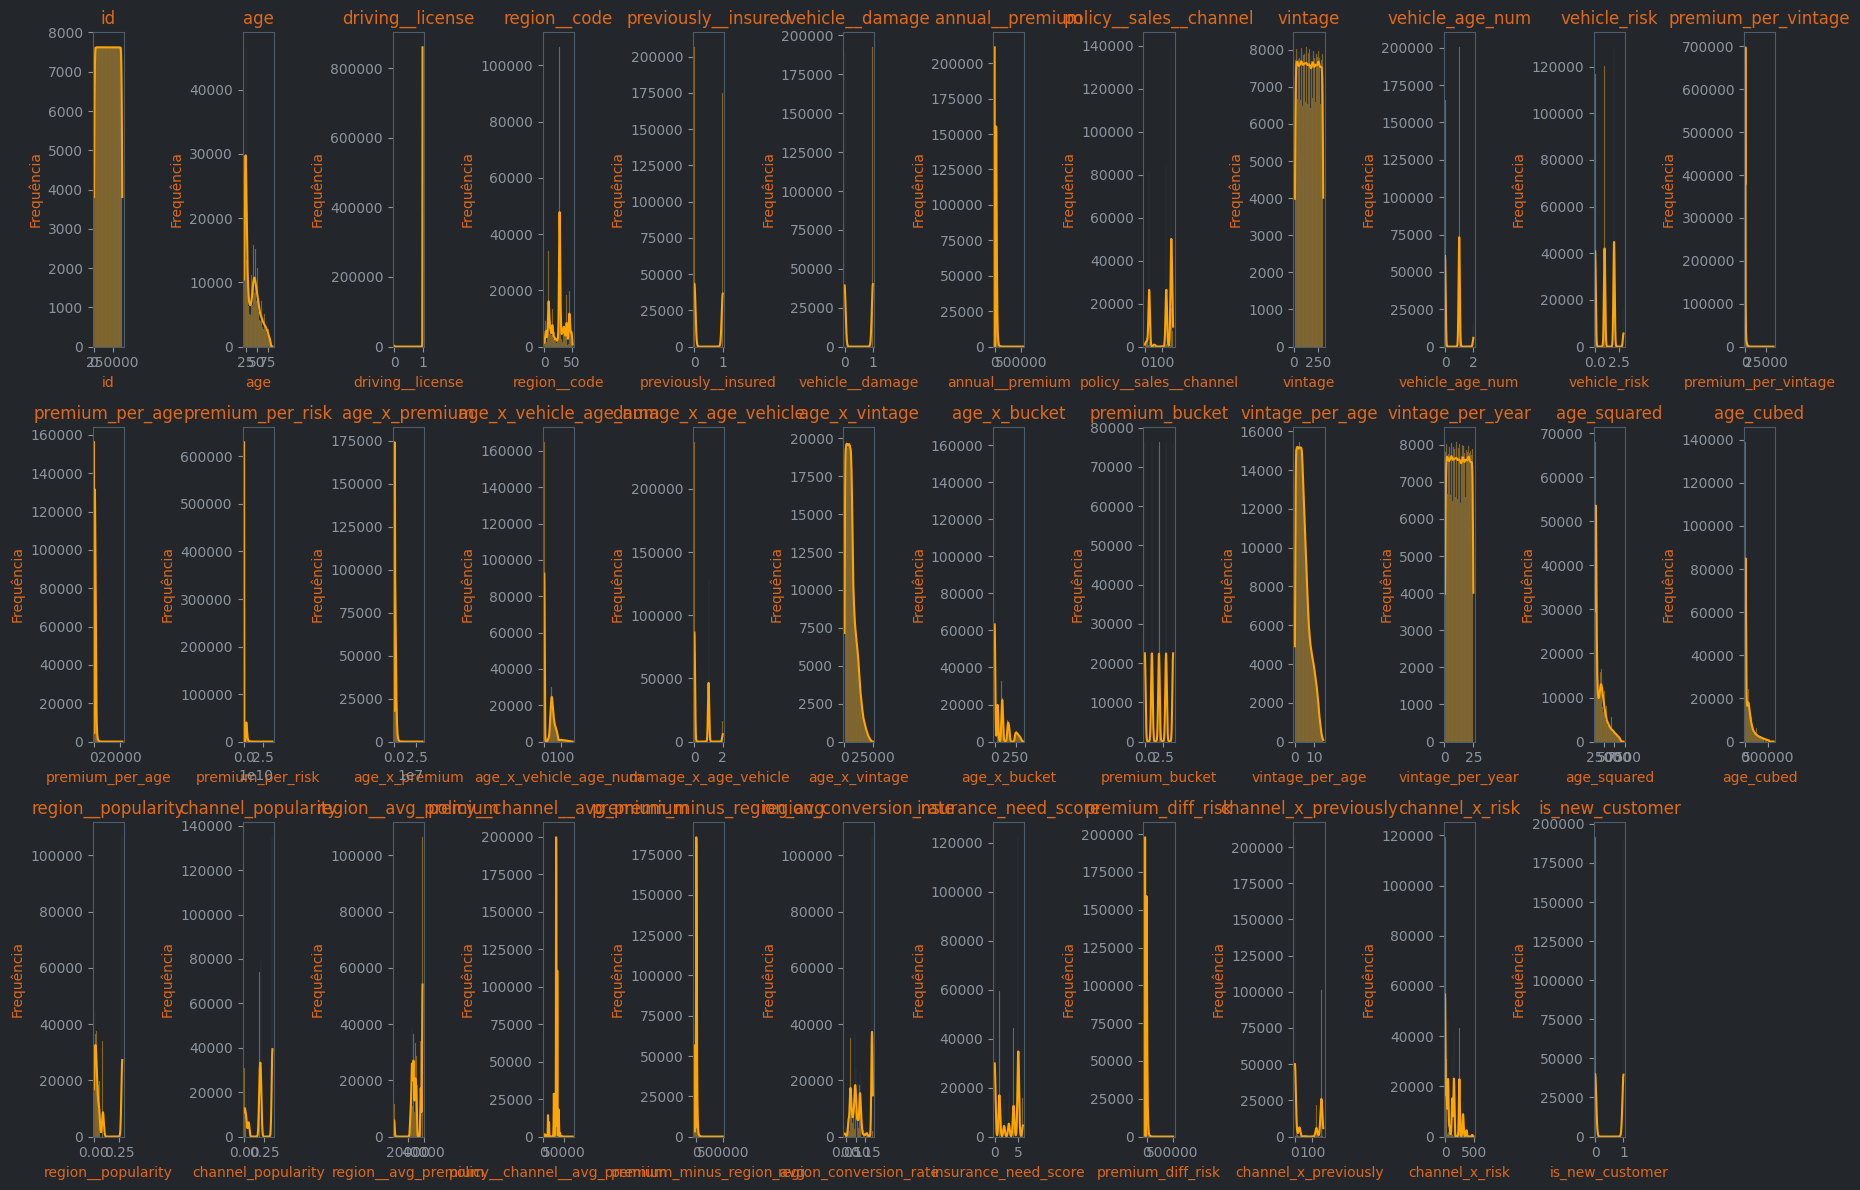

In [ ]:
numerical_cols = [col for col in df3.select_dtypes(include=['int64', 'float64']).columns if col != 'response']

plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, int(np.ceil(len(numerical_cols)/3)), i)
    sns.histplot(df3[col], bins=50, kde=True, color='orange')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequência')
plt.tight_layout()
plt.show()



**Age:**
The distribution is heavily concentrated between ages 20 and 40, with a gradual decline in higher age groups. This indicates that the dataset is composed mostly of younger customers, who tend to show higher propensity to purchase lower-value insurance products.

**Driving_license:**
Almost all customers possess a valid driver’s license, which is expected since the product is vehicle-related. Therefore, this variable has low variability and limited discriminative power.

**Region_code:**
The distribution shows spikes in specific region codes, suggesting geographic concentration of customers in certain areas. This may reflect more active local markets or regions where the campaign had stronger penetration.

**Previously_insured:**
Most customers already have previous insurance, which may indicate a more experienced audience with lower likelihood of switching insurers. Non-insured customers, on the other hand, may represent the primary target for acquisition.

**Vehicle_damage:**
The bimodal distribution (many values at both 0 and 1) reveals two well-defined groups: vehicles with and without previous damage. Customers with damage history may show lower purchase propensity or require higher premiums.

**Annual_premium:**
This variable exhibits right-skewness, with a few very high values. Most customers purchase low-cost insurance, while only a small group pays significantly higher premiums.

**Policy_sales_channel:**
A few channels concentrate the majority of interactions, indicating that certain sales approaches (such as call centers or specific partner channels) are more effective.

**Vintage:**
The distribution is nearly uniform, suggesting a wide range of relationship durations with no strong concentration in specific periods.

**Vehicle_risk:**
Three well-defined peaks are present, corresponding to risk levels derived from the vehicle’s age and condition. This is an important variable for capturing the risk profile associated with purchase propensity.

**Premium_per_vintage:**
Heavily concentrated at low values, indicating that most customers pay modest premiums relative to their relationship duration.

**Prev_damage:**
Most records indicate no prior damage, with a small portion showing damage history—possibly more inclined to seek insurance again.

**Premium_per_age:**
Strong right-skewness shows that younger customers tend to pay proportionally higher premiums, reflecting risk policies by age group.

**Region_popularity:**
A growing concentration toward the last categories suggests that a few regions contain most of the customer base, which may indicate uneven geographic distribution or stronger regional campaign performance.

**Vehicle Age:**
There is a strong concentration of customers with vehicles under 1 year and between 1 and 2 years old, with very few vehicles older than 2 years.


#### 7.1.3 Categorical Variables


C:\Users\Patryck\AppData\Local\Temp\ipykernel_14744\189216310.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df3, x=col, order=order, palette=palette)


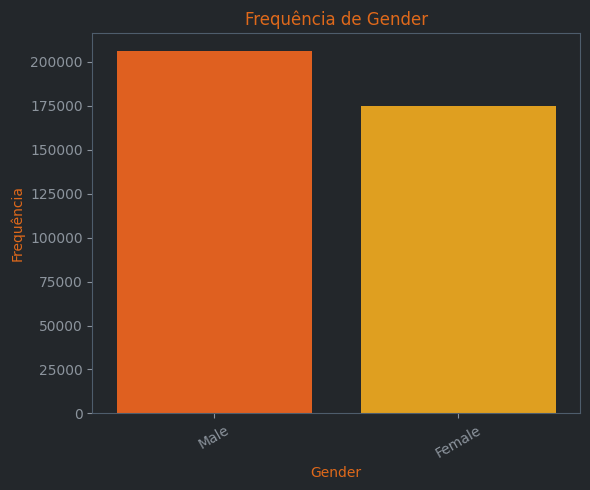

In [ ]:
categorical_cols = [
    'gender', 
]

warm_palette = sns.color_palette("autumn", n_colors=df3[categorical_cols[0]].nunique())

plt.figure(figsize=(6 * len(categorical_cols), 5))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, len(categorical_cols), i)
    order = df3[col].value_counts().index  
    n_unique = df3[col].nunique()
    palette = sns.color_palette("autumn", n_colors=n_unique)
    sns.countplot(data=df3, x=col, order=order, palette=palette)
    plt.title(f'Frequência de {col.replace("__", " ").capitalize()}')
    plt.xticks(rotation=30)
    plt.xlabel(col.replace("__", " ").capitalize())
    plt.ylabel('Frequência')
plt.tight_layout()
plt.show()


**Gender:**
The dataset contains a higher concentration of male customers, but not at an extreme level. The difference is moderate—approximately **15 to 20 thousand more men** than women.


### 7.2 Bivariate Analysis


#### H1 — Older customers (age) have a higher probability of purchasing the insurance. TRUE

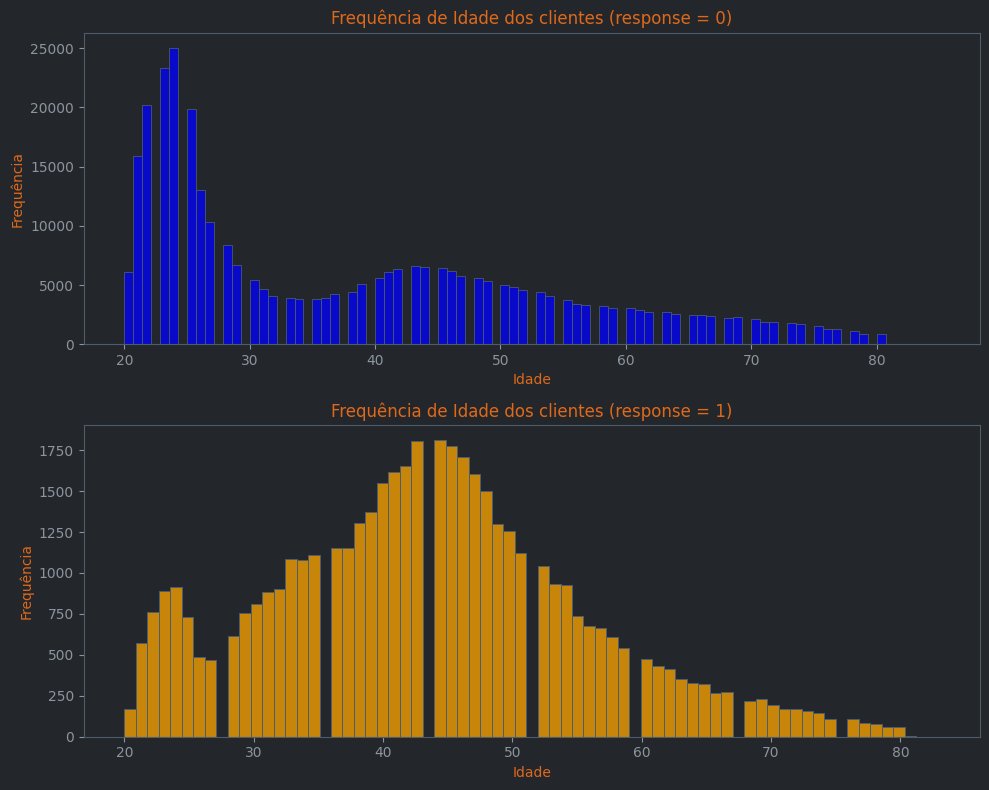

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(data=df3[df3['response'] == 0], x='age', color='blue', ax=axes[0])
axes[0].set_title('Frequência de Idade dos clientes (response = 0)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('Idade')

sns.histplot(data=df3[df3['response'] == 1], x='age', color='orange', ax=axes[1])
axes[1].set_title('Frequência de Idade dos clientes (response = 1)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('Idade')

plt.tight_layout()
plt.show()


In [ ]:
pearson_corr = df3['age'].corr(df3['response'], method='pearson')
print(f"Correlação de Pearson entre age e response: {pearson_corr:.4f}")


Correlação de Pearson entre age e response: 0.1111


#### H2 — Customers who hold a driver's license (driving_license = 1) have a higher likelihood of buying the insurance. FALSE

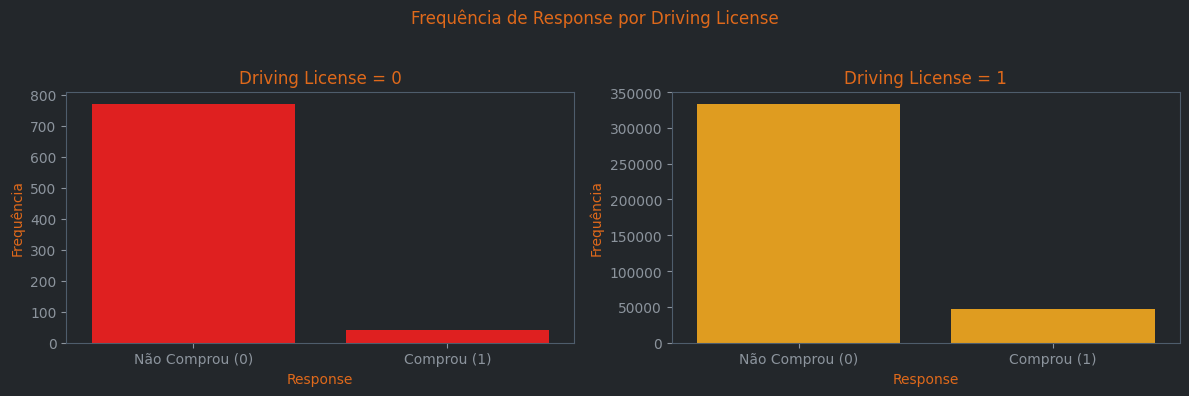

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for i, val in enumerate(sorted(df3['driving__license'].unique())):
    sns.countplot(
        data=df3[df3['driving__license'] == val],
        x='response',
        color="red" if val == 0 else "orange",
        ax=axes[i]
    )
    axes[i].set_title(f'Driving License = {val}')
    axes[i].set_xlabel('Response')
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Não Comprou (0)', 'Comprou (1)'])

plt.suptitle('Frequência de Response por Driving License')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
contingency_table = pd.crosstab(df3['driving__license'], df3['response'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

print(f"V de Cramer entre driving_license e response: {cramers_v:.4f}")


V de Cramer entre driving_license e response: 0.0101


#### H3 — Customers with previous insurance history (previously_insured = 1) have a lower propensity to purchase again. TRUE

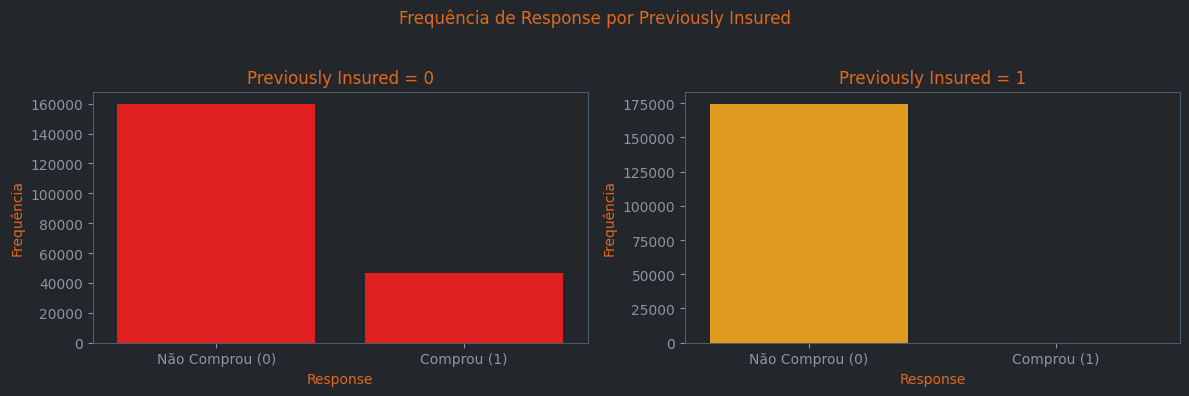

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for i, val in enumerate(sorted(df3['previously__insured'].unique())):
    sns.countplot(
        data=df3[df3['previously__insured'] == val],
        x='response',
        color="red" if val == 0 else "orange",
        ax=axes[i]
    )
    axes[i].set_title(f'Previously Insured = {val}')
    axes[i].set_xlabel('Response')
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Não Comprou (0)', 'Comprou (1)'])

plt.suptitle('Frequência de Response por Previously Insured')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:

contingency_table = pd.crosstab(df3['previously__insured'], df3['response'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

print(f"V de Cramer entre previously__insured e response: {cramers_v:.4f}")


V de Cramer entre previously__insured e response: 0.3412


#### H4 — Newer vehicles (vehicle_age = "< 1 year") are associated with higher purchase rates. FALSE

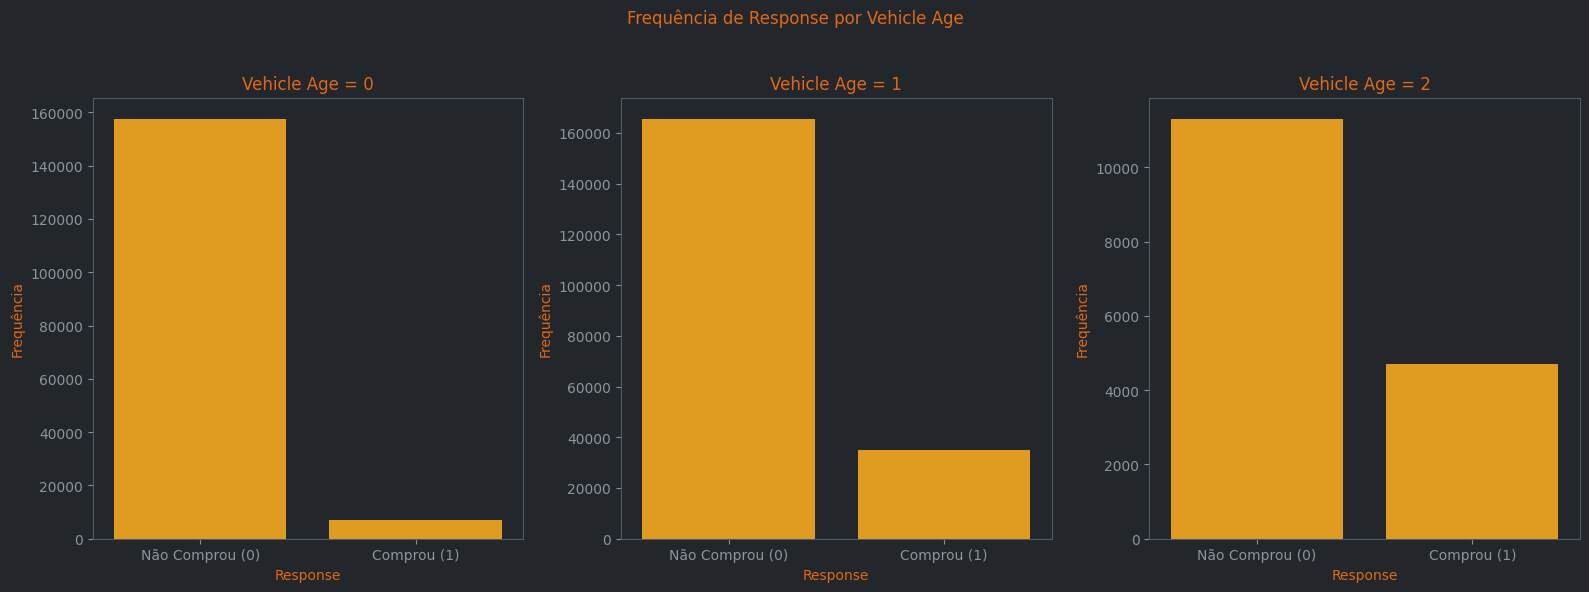

In [ ]:
vehicle_age_values = [0, 1, 2]  

fig, axes = plt.subplots(1, len(vehicle_age_values), figsize=(16, 6), sharey=False)

for i, val in enumerate(vehicle_age_values):
    sns.countplot(
        data=df3[df3['vehicle_age_num'] == val],
        x='response',
        color="orange",
        ax=axes[i]
    )
    axes[i].set_title(f'Vehicle Age = {val}')
    axes[i].set_xlabel('Response')
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Não Comprou (0)', 'Comprou (1)'])

plt.suptitle('Frequência de Response por Vehicle Age')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
pearson_corr = df3['vehicle_age_num'].corr(df3['response'], method='pearson')
print(f"Correlação de Pearson entre vehicle__age_num e response: {pearson_corr:.4f}")


Correlação de Pearson entre vehicle__age_num e response: 0.2219


#### H5 — Customers whose vehicle has suffered prior damage (vehicle_damage = 1) show a higher probability of purchasing insurance. TRUE

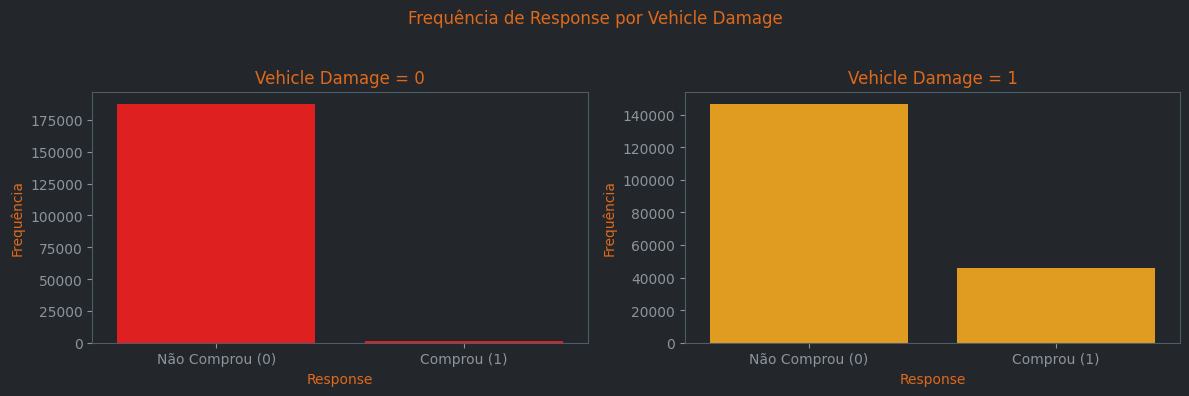

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for i, val in enumerate(sorted(df3['vehicle__damage'].unique())):
    sns.countplot(
        data=df3[df3['vehicle__damage'] == val],
        x='response',
        color="red" if val == 0 else "orange",
        ax=axes[i]
    )
    axes[i].set_title(f'Vehicle Damage = {val}')
    axes[i].set_xlabel('Response')
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Não Comprou (0)', 'Comprou (1)'])

plt.suptitle('Frequência de Response por Vehicle Damage')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:

contingency_table = pd.crosstab(df3['vehicle__damage'], df3['response'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

print(f"V de Cramer entre vehicle__damage e response: {cramers_v:.4f}")


V de Cramer entre vehicle__damage e response: 0.3544


#### H6 — Customers with higher annual premiums (annual_premium) tend to have lower conversion rates. FALSE

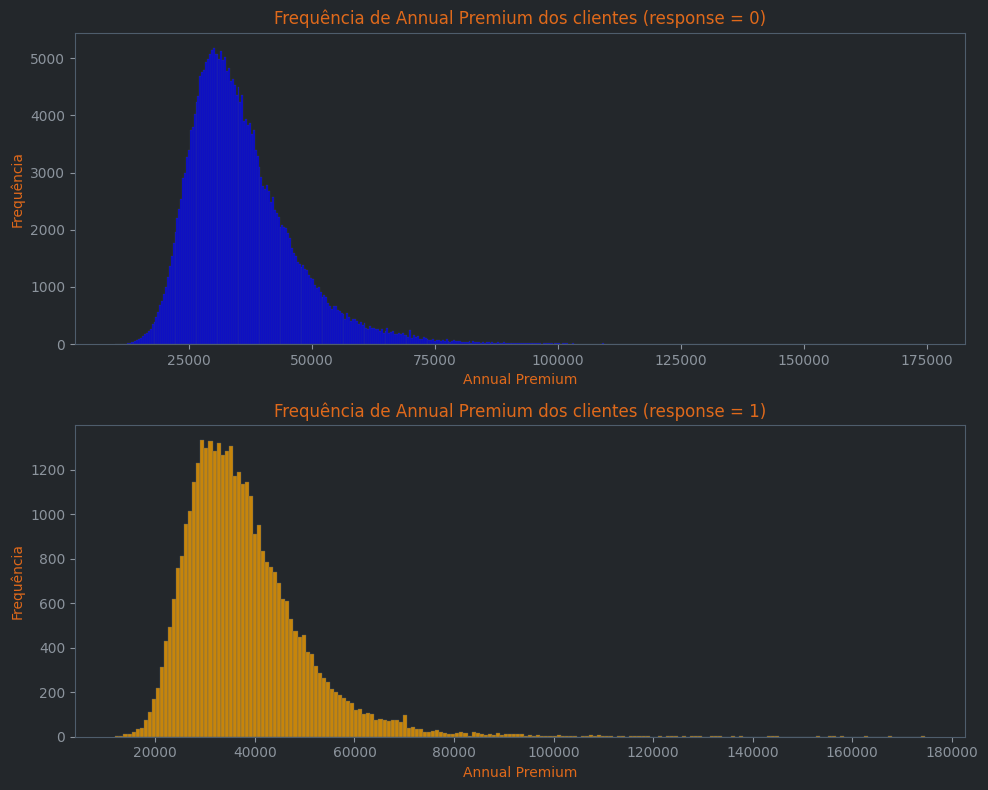

In [ ]:

df_filtrado = df3[(df3['annual__premium'] > 10000) & (df3['annual__premium'] < 175000)]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(data=df_filtrado[df_filtrado['response'] == 0], x='annual__premium', color='blue', ax=axes[0])
axes[0].set_title('Frequência de Annual Premium dos clientes (response = 0)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('Annual Premium')

sns.histplot(data=df_filtrado[df_filtrado['response'] == 1], x='annual__premium', color='orange', ax=axes[1])
axes[1].set_title('Frequência de Annual Premium dos clientes (response = 1)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('Annual Premium')

plt.tight_layout()
plt.show()


In [ ]:
pearson_corr = df3['annual__premium'].corr(df3['response'], method='pearson')
print(f"Correlação de Pearson entre annual premium e response: {pearson_corr:.4f}")

Correlação de Pearson entre annual premium e response: 0.0226


#### H7 — Certain regions (region_code) exhibit a higher propensity to purchase insurance. FALSE

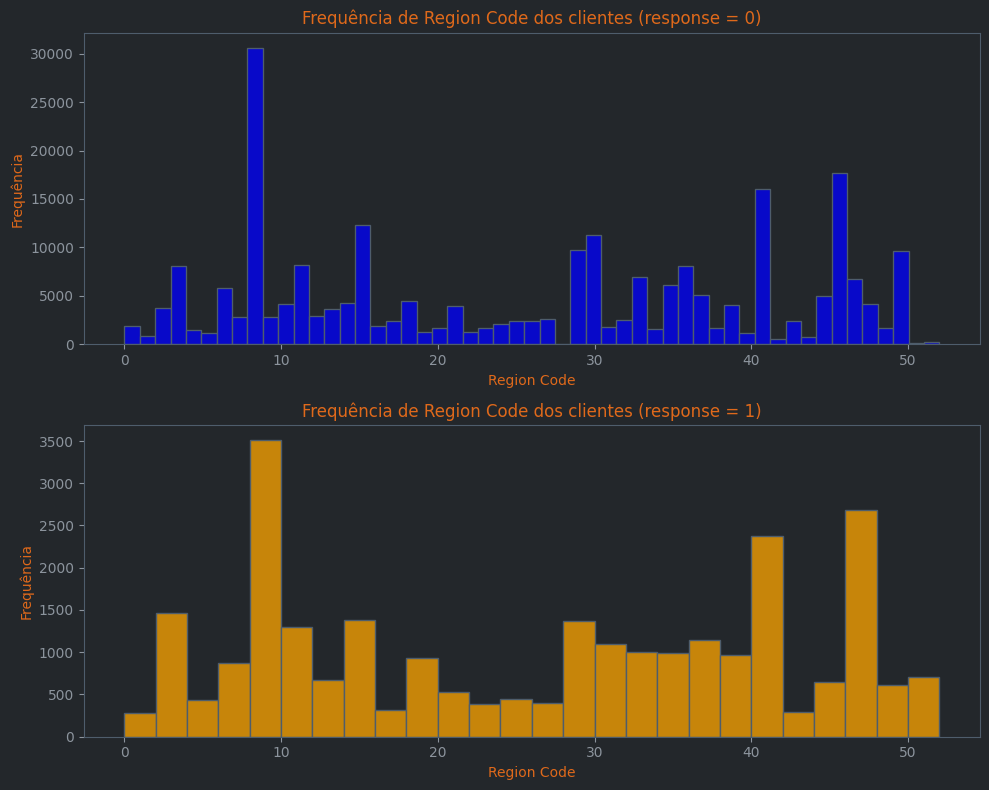

In [ ]:

df_region28 = df3[df3['region__code'] != 28]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(data=df_region28[df_region28['response'] == 0], x='region__code', color='blue', ax=axes[0])
axes[0].set_title('Frequência de Region Code dos clientes (response = 0)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('Region Code')

sns.histplot(data=df_region28[df_region28['response'] == 1], x='region__code', color='orange', ax=axes[1])
axes[1].set_title('Frequência de Region Code dos clientes (response = 1)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('Region Code')

plt.tight_layout()
plt.show()


In [ ]:
pearson_corr = df3['region__code'].corr(df3['response'], method='pearson')
print(f"Correlação de Pearson entre region code e response: {pearson_corr:.4f}")

Correlação de Pearson entre region code e response: 0.0106



#### H8 — The sales channel (policy_sales_channel) significantly influences the conversion rate. TRUE

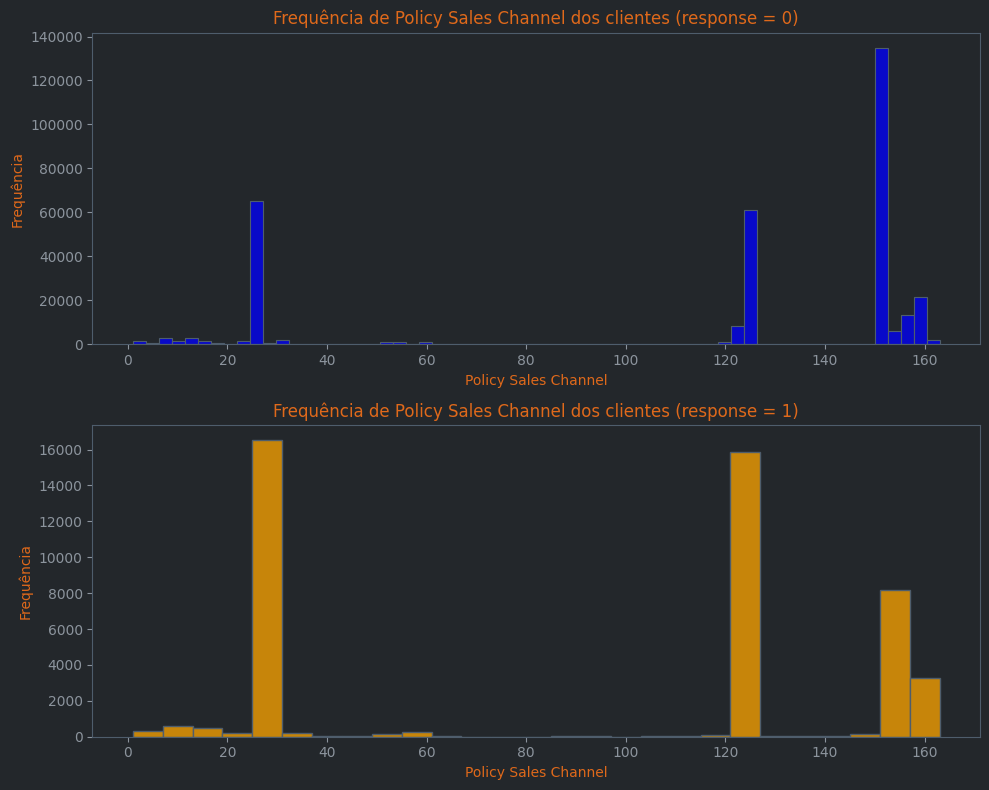

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(data=df3[df3['response'] == 0], x='policy__sales__channel', color='blue', ax=axes[0])
axes[0].set_title('Frequência de Policy Sales Channel dos clientes (response = 0)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('Policy Sales Channel')

sns.histplot(data=df3[df3['response'] == 1], x='policy__sales__channel', color='orange', ax=axes[1])
axes[1].set_title('Frequência de Policy Sales Channel dos clientes (response = 1)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('Policy Sales Channel')

plt.tight_layout()
plt.show()


In [ ]:
pearson_corr = df3['policy__sales__channel'].corr(df3['response'], method='pearson')
print(f"Correlação de Pearson entre policy sales channel e response: {pearson_corr:.4f}")

Correlação de Pearson entre policy sales channel e response: -0.1390


#### H9 — Customers with longer tenure (vintage) with the company have a higher probability of accepting the offer. FALSE


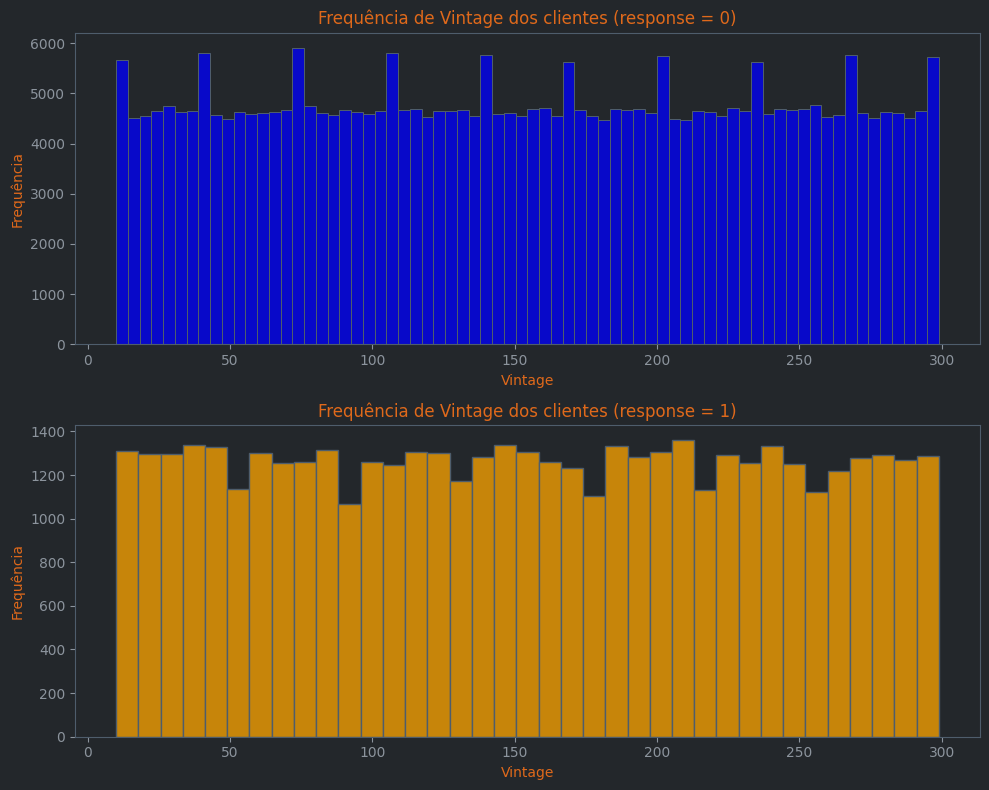

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(data=df3[df3['response'] == 0], x='vintage', color='blue', ax=axes[0])
axes[0].set_title('Frequência de Vintage dos clientes (response = 0)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('Vintage')

sns.histplot(data=df3[df3['response'] == 1], x='vintage', color='orange', ax=axes[1])
axes[1].set_title('Frequência de Vintage dos clientes (response = 1)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('Vintage')

plt.tight_layout()
plt.show()


In [ ]:
pearson_corr = df3['vintage'].corr(df3['response'], method='pearson')
print(f"Correlação de Pearson entre vintage e response: {pearson_corr:.4f}")

Correlação de Pearson entre vintage e response: -0.0011


#### H10 — Gender (gender) influences the propensity to purchase insurance. FALSE

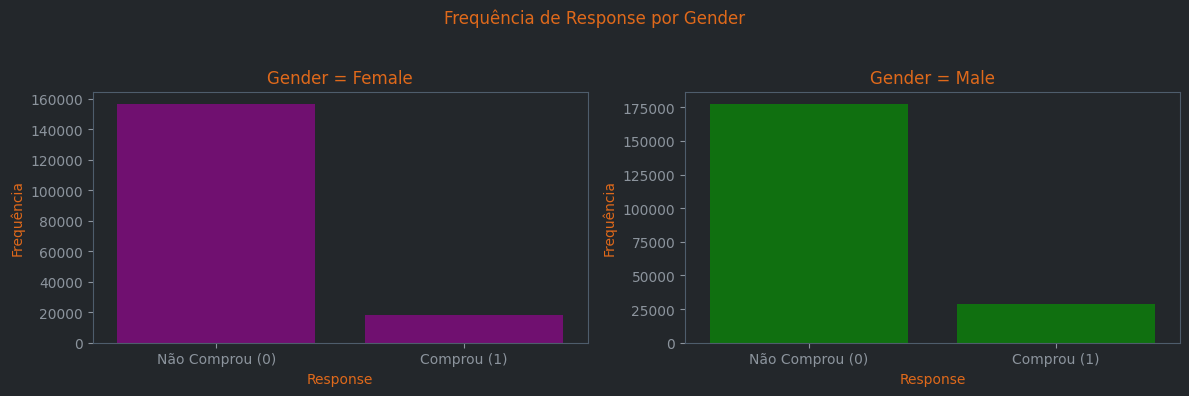

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for i, val in enumerate(sorted(df3['gender'].unique())):
    sns.countplot(
        data=df3[df3['gender'] == val],
        x='response',
        color="green" if val == 'Male' else "purple",
        ax=axes[i]
    )
    axes[i].set_title(f'Gender = {val}')
    axes[i].set_xlabel('Response')
    axes[i].set_ylabel('Frequência')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Não Comprou (0)', 'Comprou (1)'])

plt.suptitle('Frequência de Response por Gender')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:

contingency_table = pd.crosstab(df3['gender'], df3['response'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

print(f"V de Cramer entre gender e response: {cramers_v:.4f}")


V de Cramer entre gender e response: 0.0524


#### H11 — Customers with higher vehicle_risk have a lower probability of acquiring a new insurance policy. TRUE

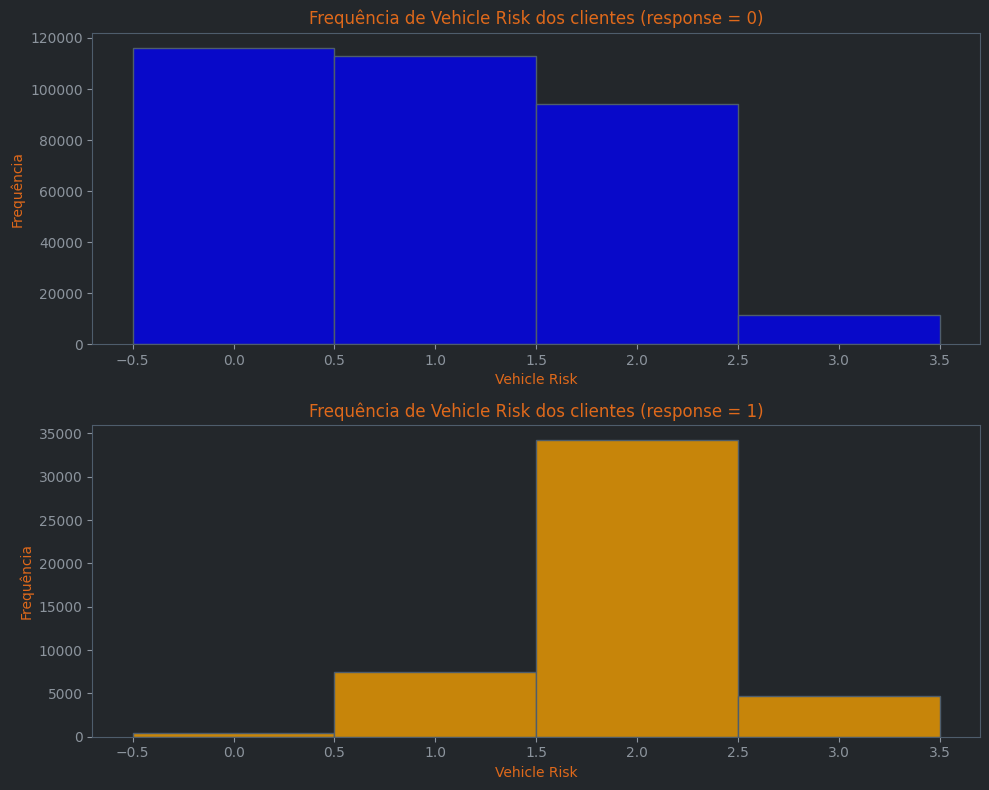

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharey=False)

sns.histplot(data=df3[df3['response'] == 0], x='vehicle_risk', color='blue', ax=axes[0], discrete = True)
axes[0].set_title('Frequência de Vehicle Risk dos clientes (response = 0)')
axes[0].set_ylabel('Frequência')
axes[0].set_xlabel('Vehicle Risk')

sns.histplot(data=df3[df3['response'] == 1], x='vehicle_risk', color='orange', ax=axes[1], discrete = True)
axes[1].set_title('Frequência de Vehicle Risk dos clientes (response = 1)')
axes[1].set_ylabel('Frequência')
axes[1].set_xlabel('Vehicle Risk')

plt.tight_layout()
plt.show()


In [ ]:
pearson_corr = df3['vehicle_risk'].corr(df3['response'], method='pearson')
print(f"Correlação de Pearson entre vehicle risk e response: {pearson_corr:.4f}")

Correlação de Pearson entre vehicle risk e response: 0.3395


## 8. Data Preparation


In [122]:
df4 = df3.copy()

### 8.1 Scaler

#### 8.1.1 Log Transformation

In [ ]:
log_transform_cols = [
    'age_x_premium',
    'premium_per_risk',
    'premium_per_age',
    'premium_per_vintage'
]

for col in log_transform_cols:
    df4[col + '_log'] = np.log1p(df4[col])
    df4.drop(columns=col, inplace=True)

#### 8.1.2 Standard Scaler

In [124]:
cols_to_scale_standard = [
    'age',
    'vintage',
    'vintage_per_age',
    'region__popularity',
    'channel_x_risk',
    'channel_x_previously',
    'insurance_need_score',
    'channel_popularity',
    'age_x_bucket',
    'age_x_vintage',
    'vehicle_age_num',
    'premium_rel_age',
    'damage_x_age_vehicle',
    'age_x_vehicle_age_num',
    'risk_alignment',
    'vehicle_risk',
    'annual__premium', 
    'premium_per_age_log', 
    'premium_per_vintage_log',
    'age_x_premium_log',
    'premium_bucket',
    'region__avg_premium',
    'policy__channel__avg_premium',
    'premium_diff_risk',
    'premium_per_risk_log',
    'premium_minus_region_avg',
    'age_cubed',
    'vintage_per_year',
    'avg_premium_same_age',
    'age_squared'
]

standard_scaler = StandardScaler()
df4[cols_to_scale_standard] = standard_scaler.fit_transform(df4[cols_to_scale_standard])


#### 8.1.3 MinMaxScaler

In [125]:
cols_to_scale_minmax = [
    'region_conversion_rate',
    'premium_age_percentile',     
]

minmax_scaler = MinMaxScaler()
df4[cols_to_scale_minmax] = minmax_scaler.fit_transform(df4[cols_to_scale_minmax])


### 8.2 Encoding

#### 8.2.1 One Hot Encoding

In [ ]:
df4['gender'] = df4['gender'].map({'Male': 1, 'Female': 0})

ohe_age = OneHotEncoder(sparse_output=False, dtype=int, drop=None)
age_bucket_encoded = ohe_age.fit_transform(df4[['age_bucket']])
age_bucket_columns = [f'age_bucket_{cat}' for cat in ohe_age.categories_[0]]
df4[age_bucket_columns] = age_bucket_encoded
df4 = df4.drop('age_bucket', axis=1)

ohe_premium = OneHotEncoder(sparse_output=False, dtype=int, drop=None)
premium_bucket_encoded = ohe_premium.fit_transform(df4[['premium_bucket']])
premium_bucket_columns = [f'premium_bucket_{cat}' for cat in ohe_premium.categories_[0]]
df4[premium_bucket_columns] = premium_bucket_encoded
df4 = df4.drop('premium_bucket', axis=1)


#### 8.2.3 Target Encoding

In [127]:
region_code_target_mean = df4.groupby('region__code')['response'].mean()
df4['region__code'] = df4['region__code'].map(region_code_target_mean)


#### 8.2.4 Frequency Encoding

In [128]:
policy_sales_freq = df4['policy__sales__channel'].value_counts(normalize=True)
df4['policy__sales__channel'] = df4['policy__sales__channel'].map(policy_sales_freq)


## 9. Feature Selection

In [129]:
df5 = df4.copy()

### 9.1 Features Importance

In [130]:
response = df5['response']
num_neg = (response == 0).sum()
num_pos = (response == 1).sum()
scale_pos_weight = num_neg / num_pos

X = df5.drop(['id', 'response'], axis=1)
y = df5['response']

xgbm_model = xgb.XGBClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)
xgbm_model.fit(X, y)

lgbm_model = lgb.LGBMClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)
lgbm_model.fit(X, y)

cat_model = CatBoostClassifier(
    iterations=300,
    random_state=42,
    verbose=0,
    scale_pos_weight=scale_pos_weight
)
cat_model.fit(X, y)

shap_sample = X.sample(n=min(1000, len(X)), random_state=42)

explainer_xgb = shap.TreeExplainer(xgbm_model)
shap_values_xgb = explainer_xgb.shap_values(shap_sample)
mean_abs_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)

feat_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_XGB': mean_abs_shap_xgb
})

explainer_lgb = shap.TreeExplainer(lgbm_model)
shap_values_lgb = explainer_lgb.shap_values(shap_sample)
if isinstance(shap_values_lgb, list):
    shap_values_lgb = shap_values_lgb[1]

mean_abs_shap_lgb = np.abs(shap_values_lgb).mean(axis=0)
feat_importance_lgb = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_LGBM': mean_abs_shap_lgb
})

explainer_cat = shap.TreeExplainer(cat_model)
shap_values_cat = explainer_cat.shap_values(shap_sample)
if isinstance(shap_values_cat, (list, tuple)):
    shap_values_cat = shap_values_cat[1]

mean_abs_shap_cat = np.abs(shap_values_cat).mean(axis=0)
feat_importance_cat = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_CAT': mean_abs_shap_cat
})

feat_importance_df = (
    feat_importance_xgb
        .merge(feat_importance_lgb, on='Feature')
        .merge(feat_importance_cat, on='Feature')
)

feat_importance_df['SHAP_XGB_NORM'] = feat_importance_df['SHAP_XGB'] / feat_importance_df['SHAP_XGB'].sum()
feat_importance_df['SHAP_LGBM_NORM'] = feat_importance_df['SHAP_LGBM'] / feat_importance_df['SHAP_LGBM'].sum()
feat_importance_df['SHAP_CAT_NORM'] = feat_importance_df['SHAP_CAT'] / feat_importance_df['SHAP_CAT'].sum()

feat_importance_df['SHAP_MEAN_NORM'] = feat_importance_df[
    ['SHAP_XGB_NORM', 'SHAP_LGBM_NORM', 'SHAP_CAT_NORM']
].mean(axis=1)

feat_importance_df = feat_importance_df.sort_values(by='SHAP_MEAN_NORM', ascending=False).reset_index(drop=True)


c:\Users\Patryck\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [131]:
feat_importance_df

,Feature,SHAP_XGB,SHAP_LGBM,SHAP_CAT,SHAP_XGB_NORM,SHAP_LGBM_NORM,SHAP_CAT_NORM,SHAP_MEAN_NORM
0,insurance_need_score,1.869370,6.455720,1.764425,0.264343,0.182554,0.245844,0.230914
1,region__code,0.226041,6.332411,0.143048,0.031964,0.179068,0.019931,0.076988
2,vintage_per_age,0.182051,4.956382,0.233489,0.025743,0.140156,0.032533,0.066144
3,channel_x_previously,0.725582,1.561159,0.202481,0.102603,0.044146,0.028212,0.058320
4,previously__insured,0.420138,0.495890,0.614735,0.059411,0.014023,0.085653,0.053029
5,vintage,0.117089,2.065337,0.241974,0.016557,0.058403,0.033715,0.036225
6,age_x_vintage,0.185885,2.069994,0.114016,0.026286,0.058535,0.015886,0.033569
7,age,0.306298,0.640326,0.200282,0.043313,0.018107,0.027906,0.029775
8,premium_per_risk_log,0.165245,1.297706,0.138548,0.023367,0.036696,0.019304,0.026456
9,channel_x_risk,0.110616,0.228766,0.389521,0.015642,0.006469,0.054273,0.025461


In [132]:

feat_importance_df_ordenado = feat_importance_df.sort_values(by='SHAP_MEAN_NORM', ascending=False).reset_index(drop=True)

feat_importance_df_ordenado['cumsum'] = feat_importance_df_ordenado['SHAP_MEAN_NORM'].cumsum()
total_importance = feat_importance_df_ordenado['SHAP_MEAN_NORM'].sum()
feat_importance_df_ordenado['cumsum_pct'] = feat_importance_df_ordenado['cumsum'] / total_importance

selected_95 = feat_importance_df_ordenado[feat_importance_df_ordenado['cumsum_pct'] <= 0.95]['Feature'].tolist()

if len(selected_95) < len(feat_importance_df_ordenado):
    selected_95.append(feat_importance_df_ordenado.iloc[len(selected_95)]['Feature'])

print(f"Quantidade de features para 95% SHAP: {len(selected_95)}")
print(selected_95)


Quantidade de features para 95% SHAP: 28
['insurance_need_score', 'region__code', 'vintage_per_age', 'channel_x_previously', 'previously__insured', 'vintage', 'age_x_vintage', 'age', 'premium_per_risk_log', 'channel_x_risk', 'premium_minus_region_avg', 'premium_per_vintage_log', 'premium_age_percentile', 'avg_premium_same_age', 'age_cubed', 'vehicle__damage', 'premium_rel_age', 'premium_diff_risk', 'premium_per_age_log', 'premium_bucket_4.267394361373278e-05', 'annual__premium', 'policy__sales__channel', 'age_x_premium_log', 'region__popularity', 'region__avg_premium', 'policy__channel__avg_premium', 'age_x_vehicle_age_num', 'channel_popularity']


### 9.2 Removing Highly Correlated Columns


In [ ]:
colunas_existentes = [col for col in selected_95 if col in X.columns]

colunas_corr = [col for col in colunas_existentes if col != 'response']
df_temp = X[colunas_corr]
corr_matrix = df_temp.corr().abs()

colunas_final = colunas_corr.copy()
colunas_removidas = []

for i in range(len(colunas_corr)):
    col1 = colunas_corr[i]
    for j in range(i + 1, len(colunas_corr)):
        col2 = colunas_corr[j]
        if col1 in colunas_final and col2 in colunas_final:
            corr_value = corr_matrix.loc[col1, col2]
            if isinstance(corr_value, (pd.Series, pd.DataFrame)):
                corr_scalar = float(np.array(corr_value).flatten()[0])
            else:
                corr_scalar = float(corr_value)
            if corr_scalar > 0.9:
                if col2 in colunas_final:
                    colunas_final.remove(col2)
                    colunas_removidas.append((col1, col2, corr_scalar))

print("Colunas removidas devido alta correlação (>0.9):")
for c1, c2, val in colunas_removidas:
    print(f"{c2} removida (corr. com {c1} = {val:.3f})")

colunas_final = [*colunas_final, 'response'] if 'response' in X.columns else colunas_final

X = X[colunas_final]

Colunas removidas devido alta correlação (>0.9):
previously__insured removida (corr. com insurance_need_score = 0.926)
vehicle__damage removida (corr. com insurance_need_score = 0.930)
age_cubed removida (corr. com age = 0.946)
premium_diff_risk removida (corr. com premium_minus_region_avg = 0.904)
annual__premium removida (corr. com premium_minus_region_avg = 0.903)
channel_popularity removida (corr. com policy__sales__channel = 1.000)


## 10. Machine Learning

In [134]:
X.to_csv('X.csv', index=False)
y.to_csv('y.csv', index=False)

In [135]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

### 10.1 KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)

In [137]:
knn.fit(X_train, y_train)

df_metricas = avaliar_metricas(knn, X_val, y_val, X_test, y_test)
display(df_metricas)

,validacao,teste
recall,0.151726,0.144616
precision,0.350541,0.341420
f1_score,0.211784,0.203173
auc_roc,0.787184,0.782758
auc_pr,0.281412,0.276875


### 10.2 Logistic Regression

In [138]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

logreg = LogisticRegression(
    max_iter=1000,
    class_weight={0: 1, 1: scale_pos_weight}
)

In [139]:
logreg.fit(X_train, y_train)

df_metricas = avaliar_metricas(logreg, X_val, y_val, X_test, y_test)
display(df_metricas)

,validacao,teste
recall,0.919722,0.919824
precision,0.280160,0.280487
f1_score,0.429491,0.429886
auc_roc,0.846804,0.847904
auc_pr,0.338930,0.341491


### 10.3 Random Forest

In [140]:
rf_model = BalancedRandomForestClassifier(
    n_estimators=1000,
    random_state=42
)

In [141]:
rf_model.fit(X_train, y_train)

df_metricas = avaliar_metricas(rf_model, X_val, y_val, X_test, y_test)
display(df_metricas)

,validacao,teste
recall,0.822853,0.827125
precision,0.302330,0.304344
f1_score,0.442192,0.444963
auc_roc,0.847454,0.847063
auc_pr,0.342138,0.339564


### 10.4 XGBoost

In [ ]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=1000,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

In [143]:
xgb_model.fit(X_train, y_train)

df_metricas = avaliar_metricas(xgb_model, X_val, y_val, X_test, y_test)
display(df_metricas)

,validacao,teste
recall,0.672732,0.672982
precision,0.313545,0.312848
f1_score,0.427733,0.427135
auc_roc,0.838524,0.836399
auc_pr,0.333043,0.327474


### 10.5 CatBoost

In [144]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

cat_model = CatBoostClassifier(
    iterations=1000,
    random_state=42,
    verbose=0,
    scale_pos_weight=scale_pos_weight
)

In [145]:
cat_model.fit(X_train, y_train)

df_metricas = avaliar_metricas(cat_model, X_val, y_val, X_test, y_test)
display(df_metricas)

,validacao,teste
recall,0.881991,0.882466
precision,0.293408,0.294597
f1_score,0.440333,0.441730
auc_roc,0.855027,0.853660
auc_pr,0.368842,0.360142


### 10.6 LightGBM

In [146]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

lgbm_model = lgb.LGBMClassifier(
    n_estimators=1000,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

In [147]:
lgbm_model.fit(X_train, y_train)

df_metricas = avaliar_metricas(lgbm_model, X_val, y_val, X_test, y_test)
display(df_metricas)

,validacao,teste
recall,0.837570,0.842967
precision,0.299751,0.301678
f1_score,0.441498,0.444338
auc_roc,0.850039,0.849807
auc_pr,0.359457,0.350783


## 11. Escolhendo o melhor modelo

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

resultados_folds = []

for train_idx, val_idx in kf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model.fit(X_train_fold, y_train_fold)
    y_val_pred_xgb = xgb_model.predict(X_val_fold)
    y_val_proba_xgb = xgb_model.predict_proba(X_val_fold)[:, 1]
    metrics_xgb = {
        'model': 'XGBoost',
        'recall': recall_score(y_val_fold, y_val_pred_xgb),
        'precision': precision_score(y_val_fold, y_val_pred_xgb),
        'f1_score': f1_score(y_val_fold, y_val_pred_xgb),
        'auc_roc': roc_auc_score(y_val_fold, y_val_proba_xgb),
        'auc_pr': average_precision_score(y_val_fold, y_val_proba_xgb)
    }
    resultados_folds.append(metrics_xgb)

    rf_model.fit(X_train_fold, y_train_fold)
    y_val_pred_rf = rf_model.predict(X_val_fold)
    y_val_proba_rf = rf_model.predict_proba(X_val_fold)[:, 1]
    metrics_rf = {
        'model': 'Random Forest',
        'recall': recall_score(y_val_fold, y_val_pred_rf),
        'precision': precision_score(y_val_fold, y_val_pred_rf),
        'f1_score': f1_score(y_val_fold, y_val_pred_rf),
        'auc_roc': roc_auc_score(y_val_fold, y_val_proba_rf),
        'auc_pr': average_precision_score(y_val_fold, y_val_proba_rf)
    }
    resultados_folds.append(metrics_rf)


    cat_model.fit(X_train_fold, y_train_fold)
    y_val_pred_cb = cat_model.predict(X_val_fold)
    y_val_pred_cb = y_val_pred_cb if hasattr(y_val_pred_cb, '__len__') else y_val_pred_cb.astype(int)
    y_val_proba_cb = cat_model.predict_proba(X_val_fold)[:, 1]
    metrics_cb = {
        'model': 'CatBoost',
        'recall': recall_score(y_val_fold, y_val_pred_cb),
        'precision': precision_score(y_val_fold, y_val_pred_cb),
        'f1_score': f1_score(y_val_fold, y_val_pred_cb),
        'auc_roc': roc_auc_score(y_val_fold, y_val_proba_cb),
        'auc_pr': average_precision_score(y_val_fold, y_val_proba_cb)
    }
    resultados_folds.append(metrics_cb)

    lgbm_model.fit(X_train_fold, y_train_fold)
    y_val_pred_lgbm = lgbm_model.predict(X_val_fold)
    y_val_proba_lgbm = lgbm_model.predict_proba(X_val_fold)[:, 1]
    metrics_lgbm = {
        'model': 'LightGBM',
        'recall': recall_score(y_val_fold, y_val_pred_lgbm),
        'precision': precision_score(y_val_fold, y_val_pred_lgbm),
        'f1_score': f1_score(y_val_fold, y_val_pred_lgbm),
        'auc_roc': roc_auc_score(y_val_fold, y_val_proba_lgbm),
        'auc_pr': average_precision_score(y_val_fold, y_val_proba_lgbm)
    }
    resultados_folds.append(metrics_lgbm)

df_resultados_folds = pd.DataFrame(resultados_folds)

df_resultados_mean = df_resultados_folds.groupby('model').mean(numeric_only=True).reset_index()

df_resultados_mean



[LightGBM] [Info] Number of positive: 37187, number of negative: 267700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2921
[LightGBM] [Info] Number of data points in the train set: 304887, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121970 -> initscore=-1.973908
[LightGBM] [Info] Start training from score -1.973908
[LightGBM] [Info] Number of positive: 37367, number of negative: 267520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 304887, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122560 -> initscore=-1.968406
[LightGBM] [Info] Start training from score -1.968406
[LightGB

,model,recall,precision,f1_score,auc_roc,auc_pr
0,CatBoost,0.888367,0.292024,0.439538,0.854095,0.364320
1,LightGBM,0.859522,0.296814,0.441240,0.850937,0.353208
2,Random Forest,0.827145,0.303575,0.444134,0.847363,0.340049
3,XGBoost,0.719598,0.310603,0.433899,0.839387,0.331686


O modelo escolhido foi o XGBOOST

## 12. Fine Tuning

### 12.1 Using Optuna Search


In [ ]:
X_full = pd.concat([X_train, X_val]).reset_index(drop=True)
y_full = pd.concat([y_train, y_val]).reset_index(drop=True)

n_trials = 120
progress_callback = OptunaProgressCallback(total_iters=n_trials)

print("Starting Optuna optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[progress_callback]
)

print("\nOptuna optimization complete!")
print("Melhor ROC AUC:", study.best_value)
print("\nMelhores parâmetros:\n")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


### 12.2 Comparing the Models

In [150]:

X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

xgb_params = {
    'n_estimators': 5235,
    'learning_rate': 0.0016809131966316687,
    'max_depth': 7,
    'min_child_weight': 6,
    'gamma': 2.5137822424516303,
    'reg_alpha': 4.565235419519645e-07,
    'reg_lambda': 1.0291112302396134e-06,
    'subsample': 0.7907965713944016,
    'colsample_bytree': 0.5375702213880523,
    'colsample_bylevel': 0.5382770946537361,
    'booster': 'gbtree',
    'scale_pos_weight': 1,
    'max_delta_step': 1,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}



xgb_model_final = xgb.XGBClassifier(**xgb_params)
xgb_model_final.fit(X_trainval, y_trainval)

y_pred = xgb_model_final.predict(X_test)

print(classification_report(y_test, y_pred))

c:\Users\Patryck\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:24:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66880
           1       0.51      0.00      0.01      9342

    accuracy                           0.88     76222
   macro avg       0.69      0.50      0.47     76222
weighted avg       0.83      0.88      0.82     76222



In [151]:
y_pred_proba = xgb_model_final.predict_proba(X_test)[:, 1]

best_threshold, best_f1 = find_best_threshold(y_test, y_pred_proba, metric="f1")
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

print(f"Melhor threshold para F1: {best_threshold:.4f} (F1: {best_f1:.4f})")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_best))

print("\nAUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR :", average_precision_score(y_test, y_pred_proba))

Melhor threshold para F1: 0.2312 (F1: 0.4609)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.86     66880
           1       0.33      0.76      0.46      9342

    accuracy                           0.78     76222
   macro avg       0.64      0.77      0.66     76222
weighted avg       0.88      0.78      0.81     76222

Matriz de Confusão:
[[52555 14325]
 [ 2254  7088]]

AUC-ROC: 0.8582670313698797
AUC-PR : 0.36885536059230806


### 12.3 Training the Model with All Data

In [156]:

xgb_params = {
    'n_estimators': 5235,
    'learning_rate': 0.0016809131966316687,
    'max_depth': 7,
    'min_child_weight': 6,
    'gamma': 2.5137822424516303,
    'reg_alpha': 4.565235419519645e-07,
    'reg_lambda': 1.0291112302396134e-06,
    'subsample': 0.7907965713944016,
    'colsample_bytree': 0.5375702213880523,
    'colsample_bylevel': 0.5382770946537361,
    'booster': 'gbtree',
    'scale_pos_weight': 1,
    'max_delta_step': 1,
    'random_state': 42,
    'eval_metric': 'logloss'
}


xgb_model_final = xgb.XGBClassifier(**xgb_params)
xgb_model_final.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,0.5382770946537361
,colsample_bynode,None
,colsample_bytree,0.5375702213880523
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [157]:
with open("../model/xgb_final_model.pkl", "wb") as f:
    pickle.dump(xgb_model_final, f)


## 13. Error Interpretation and Translation


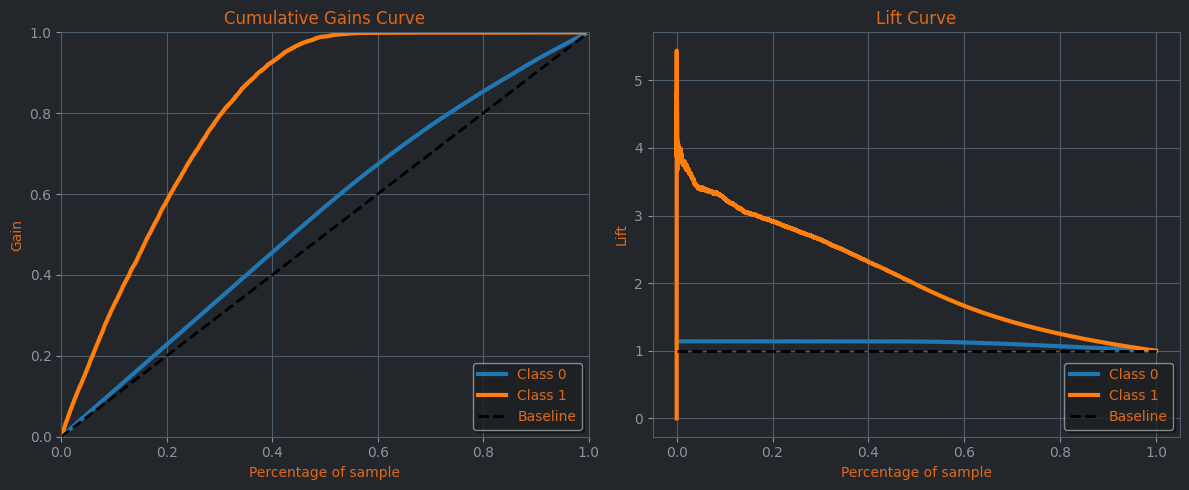

,model,precision@15244,recall@15244,f1@15244,ndcg@15244
0,xgb_final,0.357166,0.582852,0.442917,0.558331


In [ ]:
xgb_y_test_proba = xgb_model_final.predict_proba(X_test)
xgb_metrics_test = get_metrics_at_k(X_test, y_test, xgb_y_test_proba, 'xgb_final', k=15244)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
skplt.metrics.plot_cumulative_gain(y_test, xgb_y_test_proba, ax=axes[0])
skplt.metrics.plot_lift_curve(y_test, xgb_y_test_proba, ax=axes[1])

axes[0].set_title("Cumulative Gains Curve")
axes[1].set_title("Lift Curve")

plt.tight_layout()
plt.show()

base_total = 76220
pct_contato = 0.20
clientes_contatados = int(base_total * pct_contato)

custo_por_contato = 10
lucro_por_venda = 400
taxa_base = 0.15  

precision_modelo = xgb_metrics_test["precision@15244"].iloc[0] if "precision@15244" in xgb_metrics_test else 0.304  # valor 

vendas_sem_modelo = clientes_contatados * taxa_base
lucro_sem_modelo = vendas_sem_modelo * lucro_por_venda
custo_sem_modelo = clientes_contatados * custo_por_contato
lucro_liquido_sem_modelo = lucro_sem_modelo - custo_sem_modelo

vendas_com_modelo = clientes_contatados * precision_modelo
lucro_com_modelo = vendas_com_modelo * lucro_por_venda
custo_com_modelo = clientes_contatados * custo_por_contato
lucro_liquido_com_modelo = lucro_com_modelo - custo_com_modelo

ganho_total = lucro_liquido_com_modelo - lucro_liquido_sem_modelo
roi = ganho_total / lucro_liquido_sem_modelo * 100

df_financeiro = pd.DataFrame({
    'Indicador': [
        'Lucro líquido sem modelo',
        'Lucro líquido com modelo',
        'Ganho adicional',
        'ROI vs aleatório (%)'
    ],
    'Valor': [
        round(lucro_liquido_sem_modelo, 2),
        round(lucro_liquido_com_modelo, 2),
        round(ganho_total, 2),
        round(roi, 2)
    ]
})

xgb_metrics_test

In [153]:
df_financeiro

,Indicador,Valor
0,Lucro líquido sem modelo,762200.00
1,Lucro líquido com modelo,2025417.13
2,Ganho adicional,1263217.13
3,ROI vs aleatório (%),165.73


Here is the translation, preserving all formatting exactly as requested:

---

**Financial Results**

**Business Scenario (fictional but plausible)**

* Total customer base: **76,220 people**
* The model ranks all customers by their **probability of purchasing vehicle insurance**
* The company decides to contact the **top 20% most likely** → **15,244 customers**

---

**Cost and return assumptions**

| Item                                  | Value (R$) | Description                         |
| ------------------------------------- | ---------- | ----------------------------------- |
| **Cost per contact**                  | 10.00      | Phone, e-mail, or CRM outreach      |
| **Net profit per sale**               | 400.00     | Average profit per insurance policy |
| **Baseline purchase rate (no model)** | 15%        | Historical conversion rate          |

---

**Model Results**

| Metric            | Value     | Interpretation                                                         |
| ----------------- | --------- | ---------------------------------------------------------------------- |
| **Precision@20%** | **0.357** | 35.7% of contacted customers actually purchase                         |
| **Recall@20%**    | **0.583** | Captures 58.3% of all buyers in the entire customer base               |
| **F1@20%**        | **0.443** | Good balance between precision and coverage                            |
| **NDCG@20%**      | **0.558** | Excellent ranking quality: the most likely customers appear at the top |

---

**Financial Results**

| Indicator                    | Value (R$)       | Interpretation                                               |
| ---------------------------- | ---------------- | ------------------------------------------------------------ |
| **Net profit without model** | **762,200.00**   | Campaign result with random contact                          |
| **Net profit with model**    | **2,025,417.13** | Result after applying the propensity model                   |
| **Additional gain**          | **1,263,217.13** | Extra profit generated by the model                          |
| **ROI vs random**            | **≈ 165.73%**    | The model generates 2.65× more return than a random strategy |

---

**Executive Summary**

> “By applying the propensity model, we increased the campaign’s net profit from **R$ 762k to R$ 2.02 million**, using the same contact budget.
> This represents an **additional gain of R$ 1.26 million** and an **ROI of 165.7%** compared to random targeting.
> In other words, the model allows the company to **focus commercial effort on customers with the highest likelihood of conversion**, significantly multiplying campaign returns.”

---

**Conclusion**

* The model **turns an operational process into a profit lever**, directing contacts to those who truly have buying potential.
* Even with a **Precision of ~35%**, the financial impact is huge thanks to proper prioritization.
* The return increases to **2.65×** compared to the strategy without a model.
* This kind of approach shifts the campaign from *volume-based* to *intelligence-based*, reducing waste and increasing conversion.


## 14. Final Prediction


In [163]:
df_test = pd.read_csv('../data/test.csv')

In [164]:
df_test.columns = snake_case(df_test.columns)
df_test['vehicle__damage'] = df_test['vehicle__damage'].map({'Yes': 1, 'No': 0}).astype(int)
df_test['vehicle_age_num'] = df_test['vehicle__age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
df_test = df_test.drop(columns=['vehicle__age'])
df_test['vehicle_risk'] = df_test['vehicle_age_num'] + df_test['vehicle__damage']
df_test['premium_per_vintage'] = df_test['annual__premium'] / df_test['vintage']
df_test['premium_per_age'] = df_test['annual__premium'] / df_test['age']
df_test['premium_per_risk'] = df_test['annual__premium'] / (df_test['vehicle_risk'] + 1e-5)
df_test['age_x_premium'] = df_test['age'] * df_test['annual__premium']
df_test['age_x_vehicle_age_num'] = df_test['age'] * df_test['vehicle_age_num']
df_test['damage_x_age_vehicle'] = df_test['vehicle__damage'] * df_test['vehicle_age_num']
df_test['age_x_vintage'] = df_test['age'] * df_test['vintage']
df_test['age_bucket'] = pd.cut(df_test['age'], bins=[18, 30, 40, 50, 60, 100], labels=[0, 1, 2, 3, 4])
df_test['age_x_bucket'] = df_test['age'] * df_test['age_bucket'].astype(int)
df_test['premium_bucket'] = pd.qcut(df_test['annual__premium'], q=5, labels=False)
df_test['vintage_per_age'] = df_test['vintage'] / df_test['age']
df_test['vintage_per_year'] = df_test['vintage'] / 12
df_test['age_squared'] = df_test['age'] ** 2
df_test['age_cubed'] = df_test['age'] ** 3
region_counts = df_test['region__code'].value_counts(normalize=True)
df_test['region__popularity'] = df_test['region__code'].map(region_counts)
channel_counts = df_test['policy__sales__channel'].value_counts(normalize=True)
df_test['channel_popularity'] = df_test['policy__sales__channel'].map(channel_counts)
df_test['region__avg_premium'] = df_test['region__code'].map(
    df_test.groupby('region__code')['annual__premium'].mean()
)
df_test['region_conversion_rate'] = df_test['region__code'].map(conversion_by_region)
df_test['policy__channel__avg_premium'] = df_test['policy__sales__channel'].map(
    df_test.groupby('policy__sales__channel')['annual__premium'].mean()
)
df_test['premium_minus_region_avg'] = df_test['annual__premium'] - df_test['region__avg_premium']
df_test['insurance_need_score'] = (
    (df_test['previously__insured'] == 0).astype(int) * 2 +
    df_test['vehicle_risk'] +
    df_test['vehicle__damage']
)
avg_premium_by_risk = df_test.groupby('vehicle_risk')['annual__premium'].mean()
df_test['premium_diff_risk'] = df_test['annual__premium'] - df_test['vehicle_risk'].map(avg_premium_by_risk)
df_test['channel_x_previously'] = df_test['policy__sales__channel'] * df_test['previously__insured']
df_test['channel_x_risk'] = df_test['policy__sales__channel'] * df_test['vehicle_risk']
df_test['is_new_customer'] = (df_test['vintage'] < df_test['vintage'].median()).astype(int)
df_test['avg_premium_same_age'] = df_test.groupby('age')['annual__premium'].transform('mean')
df_test['premium_rel_age'] = df_test['annual__premium'] / df_test['avg_premium_same_age']
df_test['premium_age_percentile'] = df_test.groupby('age')['annual__premium'].rank(pct=True)
df_test['risk_alignment'] = df_test['insurance_need_score'] * df_test['vehicle_risk']



In [ ]:
log_transform_cols = [
    'age_x_premium',
    'premium_per_risk',
    'premium_per_age',
    'premium_per_vintage'
]

for col in log_transform_cols:
    df_test[col + '_log'] = np.log1p(df_test[col])
    df_test.drop(columns=col, inplace=True)

In [166]:
cols_to_scale_standard = [
    'age',
    'vintage',
    'vintage_per_age',
    'region__popularity',
    'channel_x_risk',
    'channel_x_previously',
    'insurance_need_score',
    'channel_popularity',
    'age_x_bucket',
    'age_x_vintage',
    'vehicle_age_num',
    'premium_rel_age',
    'damage_x_age_vehicle',
    'age_x_vehicle_age_num',
    'risk_alignment',
    'vehicle_risk',
    'annual__premium', 
    'premium_per_age_log', 
    'premium_per_vintage_log',
    'age_x_premium_log',
    'premium_bucket',
    'region__avg_premium',
    'policy__channel__avg_premium',
    'premium_diff_risk',
    'premium_per_risk_log',
    'premium_minus_region_avg',
    'age_cubed',
    'vintage_per_year',
    'avg_premium_same_age',
    'age_squared'
]


df_test[cols_to_scale_standard] = standard_scaler.transform(df_test[cols_to_scale_standard])


In [167]:
cols_to_scale_minmax = [
    'region_conversion_rate',
    'premium_age_percentile',     
]

df_test[cols_to_scale_minmax] = minmax_scaler.transform(df_test[cols_to_scale_minmax])

In [168]:
df_test['gender'] = df_test['gender'].map({'Male': 1, 'Female': 0})

age_bucket_encoded = ohe_age.transform(df_test[['age_bucket']])
age_bucket_columns = [f'age_bucket_{cat}' for cat in ohe_age.categories_[0]]
df_test[age_bucket_columns] = age_bucket_encoded
df_test = df_test.drop('age_bucket', axis=1)

premium_bucket_encoded = ohe_premium.transform(df_test[['premium_bucket']])
premium_bucket_columns = [f'premium_bucket_{cat}' for cat in ohe_premium.categories_[0]]
df_test[premium_bucket_columns] = premium_bucket_encoded
df_test = df_test.drop('premium_bucket', axis=1)

df_test['region__code'] = df_test['region__code'].map(region_code_target_mean)

df_test['policy__sales__channel'] = df_test['policy__sales__channel'].map(policy_sales_freq)

In [169]:
df_test = df_test[['id'] + list(X.columns)]
y_proba_test = xgb_model_final.predict_proba(df_test.drop('id', axis=1))
df_test['score'] = y_proba_test[:, 1]
df_test = df_test.sort_values(by='score', ascending=False).reset_index(drop=True)
df_test = df_test[['id', 'score']]

In [170]:
df_test['score'] = y_proba_test[:, 1]
df_test = df_test.sort_values(by='score', ascending=False).reset_index(drop=True)
df_test = df_test[['id', 'score']]

In [ ]:
df_test.to_csv('../data/test_final.csv', index=False)

In [171]:
df_test.head().T

,0,1,2,3,4
id,390147.000000,463439.000000,504617.000000,458736.000000,463408.000000
score,0.550305,0.536014,0.534712,0.533745,0.531486



## 15. Conclusion

The results show that the propensity model presents **excellent predictive performance** and significant financial impact for the *cross-sell* campaign. At the threshold optimized to maximize the F1-score (**0.2312**), the model reaches an **F1 = 0.4609**, balancing precision and recall for the minority class.

---

**Classification Report**

| Class            | Precision | Recall | F1-score | Support |
| ---------------- | --------- | ------ | -------- | ------- |
| **0**            | 0.96      | 0.79   | 0.86     | 66,880  |
| **1**            | 0.33      | 0.76   | 0.46     | 9,342   |
| **Accuracy**     | —         | —      | **0.78** | 76,222  |
| **Macro Avg**    | 0.64      | 0.77   | 0.66     | 76,222  |
| **Weighted Avg** | 0.88      | 0.78   | 0.81     | 76,222  |

**Confusion Matrix**

|                    | Predicted 0 | Predicted 1 |
| ------------------ | ----------- | ----------- |
| **Class 0 (real)** | 52,555      | 14,325      |
| **Class 1 (real)** | 2,254       | 7,088       |

**Global Metrics**

| Metric      | Value  |
| ----------- | ------ |
| **AUC-ROC** | 0.8583 |
| **AUC-PR**  | 0.3689 |

---

These results are especially relevant in a **highly imbalanced problem**, where the positive class represents a small but highly valuable portion of the business. The model demonstrates strong ability to **recover most buyers** (76% recall in the positive class), even with moderate precision—an appropriate trade-off in scenarios where each correctly identified customer generates high financial return.

When applied to the ranking of the **top 20% most likely customers**, the performance translates directly into commercial gains:

**Financial Results**

| Indicator                    | Value (R$)   | Interpretation                      |
| ---------------------------- | ------------ | ----------------------------------- |
| **Net profit without model** | 762,200.00   | Random contact                      |
| **Net profit with model**    | 2,025,417.13 | Using propensity ranking            |
| **Additional gain**          | 1,263,217.13 | Extra profit generated by the model |
| **ROI vs random**            | 165.73%      | 2.65× more return                   |

---

> “By applying the propensity model, we increased the campaign’s net profit from **R$ 762 thousand to R$ 2.02 million**, keeping the same number of contacts.
> This result represents an **additional gain of R$ 1.26 million** and an **ROI of 165.7%** compared to the random strategy.
> The model allows us to **focus commercial efforts on customers with the highest probability of purchase**, multiplying returns without increasing costs.”

---

**In Other Words**

* The model **transforms the operation into a data-driven strategy**, prioritizing customers with higher probability of conversion.
* Even with **moderate precision (0.33) for the positive class**, the high **recall (0.76)** ensures that most potential buyers are identified.
* The financial impact is significant: **2.65× more return** without increasing the number of contacts.
* The campaign shifts from a volume-based approach to one guided by **predictive intelligence**, reducing waste and substantially increasing conversion.
